<a href="https://colab.research.google.com/github/gtharun04/Tesco-Grocery-Analysis/blob/main/BIG_DATA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Big Data Coursework - Brief

## Data Processing and Machine Learning in the Cloud 

This is the **INM432 Big Data coursework 2022**. 
This coursework contains extended elements of **theory** and **practice**, mainly around parallelisation of tasks withSpark and a bit about parallel training using TensorFlow.   

## Code and Report

Your tasks include parallelization in PySpark, extension, evaluation, and theoretical reflection. 
Please complete and submit the **coding tasks** in a copy of **this notebook**. 
Write your code in the **indicated cells** and **include** the **output** in the submitted notebook.  
Make sure that **your code contains comments** on its **stucture** and explanations of its **purpose**. 

Provide also a **report** with the **textual answers in a separate document**.  
Include **screenshots** from the Google Cloud web interface (don't use the SCREENSHOT function that Google Cloud provides, but take a picture of the graphs you see for the VMs) and result tables, as well as written text about the analysis. 

## Submission

Download and submit **your version of this notebook** as an **.ipynb** file and also submit a **shareable link** to your notebook on Colab in your report (created with the Colab 'Share' function) (**and don’t change the online version after submission**). 

Further, provide your **report as a PDF document**. **State the number of words** in the document at the end. The report should **not have more than 2000 words**.  




## Introduction and Description

This coursework focuses on parallelisation and scalability in the cloud with Spark and TesorFlow/Keras. 
We start with code based on **lessons 3 and 4** of the [*Fast and Lean Data Science*](https://github.com/GoogleCloudPlatform/training-data-analyst/tree/master/courses/fast-and-lean-data-science) course by Martin Gorner. 
What we will do here is **parallelise** **pre-processing**, **measuring** and **machine learning** in the cloud and we will perform **evaluation** and **analysis** on the cloud performance, as well as **theoretical discussion**. 

This coursework contains *5 sections**. 

### Section 0

This section just contains some necessary code for setting up the environment. It has no tasks for you (but do read the code and comments). 

### Section 1 
Section 1 is about preprocessing a set of image files.
We will work with a public dataset “Flowers” (3600 images, 5 classes). 
This is not a vast dataset, but it keeps the tasks more manageable for development and you can scale up later, if you like. 

In **'Getting Started'** we will work through the data preprocessing code from *Fast and Lean Data Science* which uses TensorFlow's `tf.data` package. 
There is no task for you here, but you will need to re-use some of this code later. 

In **Task 1** you will **parallelise the data preprocessing in Spark**, using Google Cloud (GC) Dataproc. 
This involves adapting the code from 'Getting Started' to use Spark and running it in the cloud. 

### Section 2 
In **Section 2** we are going to **measure the speed of reading data** in the cloud. In **Task  2** we will **paralellize the measuring** of different configurations **using Spark**.

### Section 3

In Section 3, we will **use the pre-processed data in Tensorflow/Keras**. 
We will use the GC **AI-Platform** (formerly Cloud ML) in **Task 3** and **test different parallelisation approaches for multiple GPUs**. 

### Section 4

This section is about the theoretical discussion, based on to two papers, in **Task 4**. The answers should be given in the PDF report. 

### General points

For **all coding tasks**, take the **time of the operations** and for the cloud operations, get performance **information from the web interfaces** for your reporting and analysis. 

The **tasks** are **mostly independent**. The later tasks can mostly be addressed without needing the solution to the earlier ones.  

# Section 0: Set-up

You need to run the **imports and authentication every time you work with this notebook**. 
Use the **local Spark** installation for development before you send jobs to the cloud. 

Read through this section once and **fill in the project ID the first time**, then you can just run straight throught this at the beginning of each session - except for the two authentication cells. 

### Imports

We import some **packages that will be needed throughout**. 
For the **code that runs in the cloud**, we will need **separate import sections** that will need to be partly different from the one below. 


In [ ]:
import os, sys, math
import numpy as np
import scipy as sp
import scipy.stats
import time
import datetime
import string
import random
from matplotlib import pyplot as plt
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
import pickle

Tensorflow version 2.8.0


### Cloud and Drive authentication

This section **starts with the two interactive authentications**.

First, we mount Google Drive for persistent local storage and create a directory `DB-CW` thay you can use for this work. 

In [ ]:
print('Mounting google drive...')
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/MyDrive"
!mkdir BD-CW
%cd "/content/drive/MyDrive/BD-CW"

Mounting google drive...
Mounted at /content/drive
/content/drive/MyDrive
mkdir: cannot create directory ‘BD-CW’: File exists
/content/drive/MyDrive/BD-CW


Next, we authenticate with the GCS to enable access to Dataproc and AI-Platform.

In [ ]:
import sys
if 'google.colab' in sys.modules:
    from google.colab import auth
    auth.authenticate_user()

It is useful to **create a new Google Cloud project** for this coursework. You can do this on the [GC Console page](https://console.cloud.google.com) by clicking on the entry at the top, right of the *Google Cloud Platform* and choosing *New Project*. **Copy** the **generated project ID** to the next cell. Also **enable billing** and the **Compute, Storage and Dataproc** APIs like we did during the labs.

We also specify the **default project and region**. The REGION should be `us-central1` as that seems to be the only one that reliably works with the free credit. 
This way we don't have to specify this information every time we access the cloud.  

In [ ]:
PROJECT = 'airy-lodge-348916'  ### USE YOUR PROJECT ID HERE. ### 
!gcloud config set project $PROJECT
REGION = 'asia-southeast1'

# I have used asia-southeast1 location because it has few default GPU's which are used in section 3.
# This is my 4 google account where in first 2 google accounts I was unable to get 8 CPU's in a cluster which became very hard to interpret the results.
# For the 3rd account, I couldn't get any GPU allocation. all the GPU's show 0 in count.
# As per the suggestion of the professor, tried creating this account with different region and was able to get P4 GPU's but not K80's
# Hence I copied all the work I have done till Section 2 to this account and used P4 GPU's in Section 3. P4 GPU's also has it's own disadvantages, which we will see in section 3c
CLUSTER = '{}-cluster'.format(PROJECT)
!gcloud config set compute/region $REGION
!gcloud config set dataproc/region $REGION    

!gcloud config list # show some information

Updated property [core/project].
Updated property [compute/region].
Updated property [dataproc/region].
[component_manager]
disable_update_check = True
[compute]
region = asia-southeast1
[core]
account = tharunkambam@gmail.com
project = airy-lodge-348916
[dataproc]
region = asia-southeast1

Your active configuration is: [default]


With the cell below, we **create a storage bucket** that we will use later for **global storage**. 
If the bucket exists you will see a "ServiceException: 409 ...", which does not cause any problems. 
**You must create your own bucket to have write access.**

In [ ]:
BUCKET = 'gs://{}-storage'.format(PROJECT)
!gsutil mb $BUCKET

Creating gs://airy-lodge-348916-storage/...
ServiceException: 409 A Cloud Storage bucket named 'airy-lodge-348916-storage' already exists. Try another name. Bucket names must be globally unique across all Google Cloud projects, including those outside of your organization.


The cell below just **defines some routines for displaying images** that will be **used later**. You can see the code by double-clicking, but you don't need to study this.

In [ ]:
#@title Utility functions for image display [RUN THIS TO ACTIVATE] { display-mode: "form" }
def display_9_images_from_dataset(dataset):
  plt.figure(figsize=(13,13))
  subplot=331
  for i, (image, label) in enumerate(dataset):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image.numpy().astype(np.uint8))   
    plt.title(str(label.numpy()), fontsize=16)
    # plt.title(label.numpy().decode(), fontsize=16)
    subplot += 1
    if i==8:
      break
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()

def display_training_curves(training, validation, title, subplot):
  if subplot%10==1: # set up the subplots on the first call
    plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
    plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.set_facecolor('#F8F8F8')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])

def dataset_to_numpy_util(dataset, N):
    dataset = dataset.batch(N)
    for images, labels in dataset:
        numpy_images = images.numpy()
        numpy_labels = labels.numpy()
        break;
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
  correct = (label == correct_label)
  return "{} [{}{}{}]".format(CLASSES[label], str(correct), ', shoud be ' if not correct else '',
                              CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=16, color='red' if red else 'black')
    return subplot+1

def display_9_images_with_predictions(images, predictions, labels):
  subplot=331
  plt.figure(figsize=(13,13))
  classes = np.argmax(predictions, axis=-1)
  for i, image in enumerate(images):
    title, correct = title_from_label_and_target(classes[i], labels[i])
    subplot = display_one_flower(image, title, subplot, not correct)
    if i >= 8:
      break;
              
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()
  

### Install Spark locally for quick testing 

You can use the cell below to **install Spark locally on this Colab VM** as in the labs, to do quicker small-scale interactive testing. Using the spark in the cloud with dataproc is still required for the final version. 

We are using not the up-to date version of Spark. This is  because restrictions in the Google Cloud free tier make it preferable to use the old version there. 

In [ ]:
%cd
!apt-get update -qq
!apt-get install openjdk-8-jdk-headless -qq >> /dev/null # send any output to null device
!tar -xzf "/content/drive/My Drive/Big_Data/data/spark/spark-2.4.8-bin-hadoop2.7.tgz" # unpack 

!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
#os.environ["SPARK_HOME"] = "/root/spark-3.2.1-bin-hadoop2.7"
os.environ["SPARK_HOME"] = "/root/spark-2.4.8-bin-hadoop2.7"
import findspark
findspark.init()
import pyspark
print(pyspark.__version__)
sc = pyspark.SparkContext.getOrCreate()
print(sc)

/root
2.4.8
<SparkContext master=local[*] appName=pyspark-shell>


# Section 1: Data pre-processing

This section is about the **pre-processing of a dataset** for deep learning with Keras/Tensorflow. 
The tasks are about **parallelisation** and **analysis** the performance of the cloud services. 

## 1.1 Getting started 

In this section, we get started with the data pre-processing. The code is based on lecture 3 of the 'Fast and Lean Data Science' course.

This code is based on using the TensorFlow `tf.data` package, which offers mechanisms for map functions. Your task will be to apply the same approach   


We start by **setting some variables for the *Flowers* dataset**.

In [ ]:
GCS_PATTERN = 'gs://flowers-public/*/*.jpg' # glob  pattern for input files
PARTITIONS = 16 # no of partitions we will use later 
TARGET_SIZE = [192, 192] # target resolution for the images
CLASSES = [b'daisy', b'dandelion', b'roses', b'sunflowers', b'tulips']
    # labels for the data (folder names)

We **read the image files** from the public GCS bucket that contains the *Flowers* dataset. 
**TensorFlow** class has **functions** to execute glob patterns that we use to calculate the the number of images in total and per partition (rounded up as we can deal with parts of images).

In [ ]:
nb_images = len(tf.io.gfile.glob(GCS_PATTERN)) # number of images
partition_size = math.ceil(1.0 * nb_images / PARTITIONS) # images per partition (float)
print("GCS_PATTERN matches {} images, to be divided into {} partitions with up to {} images each.".format(nb_images, PARTITIONS, partition_size))


GCS_PATTERN matches 3670 images, to be divided into 16 partitions with up to 230 images each.


### Map functions

In order to read use the images for learning, they need to be **preprocessed** (decoded, resized, cropped, and potentially recompressed). 
Below are **map functions** for these steps. 
You **don't need to study** about the **internals of these functions** in detail. 

In [ ]:
def decode_jpeg_and_label(filepath):
    # extracts the image data and creates a class label, based on the filepath 
    bits = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(bits)
    # parse flower name from containing directory
    label = tf.strings.split(tf.expand_dims(filepath, axis=-1), sep='/')
    label2 = label.values[-2]
    return image, label2

def resize_and_crop_image(image, label):
    # Resizes and cropd using "fill" algorithm:
    # always make sure the resulting image is cut out from the source image 
    # so that it fills the TARGET_SIZE entirely with no black bars 
    # and a preserved aspect ratio.
    w = tf.shape(image)[0]
    h = tf.shape(image)[1]
    tw = TARGET_SIZE[1]
    th = TARGET_SIZE[0]
    resize_crit = (w * th) / (h * tw)
    image = tf.cond(resize_crit < 1,
                    lambda: tf.image.resize(image, [w*tw/w, h*tw/w]), # if true
                    lambda: tf.image.resize(image, [w*th/h, h*th/h])  # if false
                    )
    nw = tf.shape(image)[0]
    nh = tf.shape(image)[1]
    image = tf.image.crop_to_bounding_box(image, (nw - tw) // 2, (nh - th) // 2, tw, th)
    return image, label

def recompress_image(image, label):
    # this reduces the amount of data, but takes some time
    image = tf.cast(image, tf.uint8)
    image = tf.image.encode_jpeg(image, optimize_size=True, chroma_downsampling=False)
    return image, label

With `tf.data`  we can apply the decoding and resizing functions on the fly and try reading from the dataset.

In [ ]:
dsetFiles = tf.data.Dataset.list_files(GCS_PATTERN) # This also shuffles the images
dsetDecoded = dsetFiles.map(decode_jpeg_and_label)
dsetResized = dsetDecoded.map(resize_and_crop_image)  

We can also look at some images using the image display function defined above (the one with the hidden code).

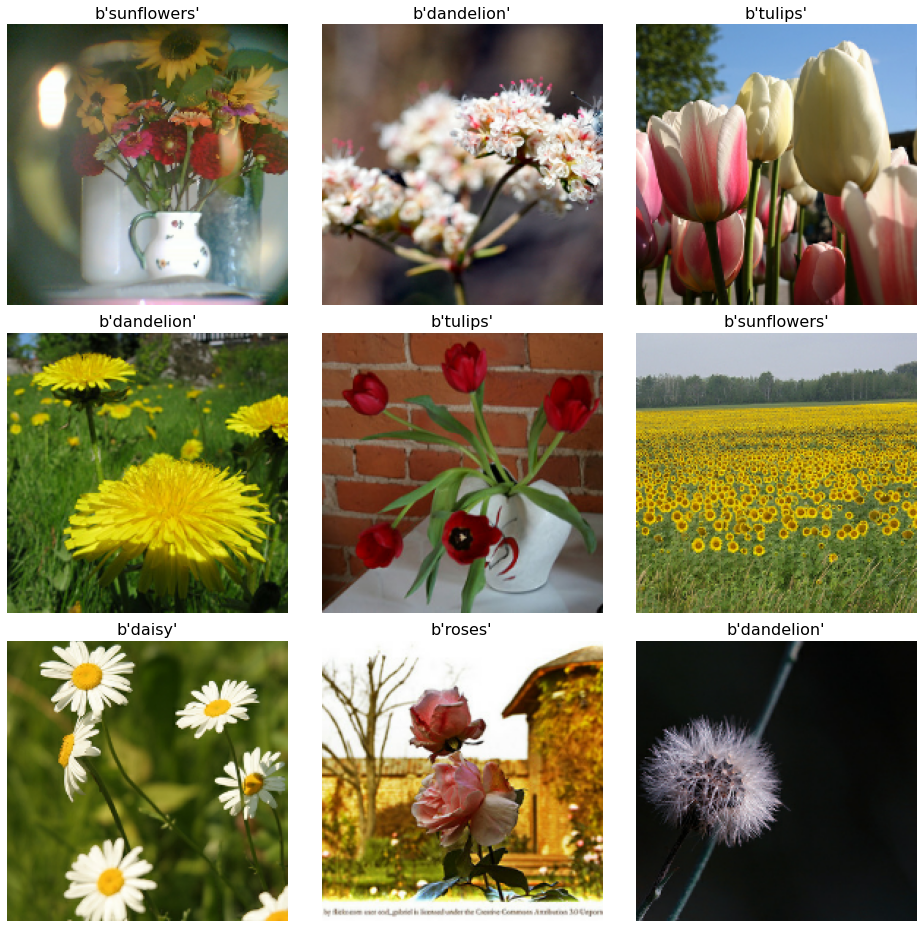

In [ ]:
display_9_images_from_dataset(dsetResized)

Now, let's test continuous reading from the dataset. We can see that reading the first 100 files already takes some time.

In [ ]:
sample_set = dsetResized.batch(10).take(10) # take 10 batches of 10 images for testing
for image, label in sample_set: 
    print("Image batch shape {}, {})".format(image.numpy().shape,
        [lbl.decode('utf8') for lbl in label.numpy()]))

Image batch shape (10, 192, 192, 3), ['tulips', 'dandelion', 'tulips', 'daisy', 'tulips', 'dandelion', 'dandelion', 'dandelion', 'dandelion', 'roses'])
Image batch shape (10, 192, 192, 3), ['sunflowers', 'tulips', 'tulips', 'dandelion', 'tulips', 'daisy', 'daisy', 'sunflowers', 'sunflowers', 'dandelion'])
Image batch shape (10, 192, 192, 3), ['roses', 'dandelion', 'tulips', 'roses', 'sunflowers', 'tulips', 'dandelion', 'tulips', 'sunflowers', 'dandelion'])
Image batch shape (10, 192, 192, 3), ['sunflowers', 'tulips', 'daisy', 'tulips', 'dandelion', 'daisy', 'daisy', 'sunflowers', 'daisy', 'dandelion'])
Image batch shape (10, 192, 192, 3), ['daisy', 'tulips', 'dandelion', 'dandelion', 'roses', 'roses', 'roses', 'roses', 'daisy', 'dandelion'])
Image batch shape (10, 192, 192, 3), ['dandelion', 'sunflowers', 'roses', 'tulips', 'dandelion', 'tulips', 'sunflowers', 'dandelion', 'tulips', 'sunflowers'])
Image batch shape (10, 192, 192, 3), ['roses', 'dandelion', 'dandelion', 'sunflowers', 'd

## 1.2 Improving Speed 

Using individual image files didn't look very fast. The 'Lean and Fast Data Science' course introduced **two techniques to improve the speed**.


### Recompress the images
By **compressing** the images in the **reduced resolution** we save on the size. 
This **costs some CPU time**, but **saves network and disk bandwith**, especially when the data are **read multiple times**. 


In [ ]:
# This is a quick test to get an idea how long recompressions takes.  
dataset4 = dsetResized.map(recompress_image)
test_set = dataset4.batch(10).take(10)
for image, label in test_set:
    print("Image batch shape {}, {})".format(image.numpy().shape, [lbl.decode('utf8') for lbl in label.numpy()])) 

Image batch shape (10,), ['dandelion', 'daisy', 'tulips', 'roses', 'daisy', 'sunflowers', 'sunflowers', 'sunflowers', 'daisy', 'dandelion'])
Image batch shape (10,), ['tulips', 'sunflowers', 'roses', 'dandelion', 'dandelion', 'sunflowers', 'daisy', 'dandelion', 'tulips', 'sunflowers'])
Image batch shape (10,), ['tulips', 'daisy', 'tulips', 'tulips', 'tulips', 'daisy', 'tulips', 'sunflowers', 'dandelion', 'dandelion'])
Image batch shape (10,), ['dandelion', 'roses', 'sunflowers', 'tulips', 'sunflowers', 'tulips', 'tulips', 'roses', 'roses', 'tulips'])
Image batch shape (10,), ['tulips', 'roses', 'sunflowers', 'tulips', 'daisy', 'dandelion', 'tulips', 'sunflowers', 'roses', 'tulips'])
Image batch shape (10,), ['daisy', 'dandelion', 'tulips', 'daisy', 'roses', 'daisy', 'dandelion', 'dandelion', 'dandelion', 'roses'])
Image batch shape (10,), ['tulips', 'dandelion', 'daisy', 'roses', 'dandelion', 'dandelion', 'daisy', 'tulips', 'roses', 'dandelion'])
Image batch shape (10,), ['sunflowers',

### Write the dataset to TFRecord files

By writing **multiple preprocessed samples into a single file**, we can make further speed gains. 
We distribute the data over **partitions** to facilitate **parallelisation** when the data are used. 
First we need to **define a location** where we want to put the file. 

In [ ]:
GCS_OUTPUT = BUCKET + '/tfrecords-jpeg-192x192-2/flowers'  # prefix for output file names

Now we can **write the TFRecord files** to the bucket. 

Running the cell takes some time and **only needs to be done once** or not at all, as you can use the publicly available data for the next few cells. For convenience I have commented out the call to `write_tfrecords` at the end of the next cell. You don't need to run it (it takes some time), but you'll need to use the code below later.Again, you don't need to study the first three functions' internals, only the `write_tfrecord` function is relevant.  

There are **ready-made pre-processed data** versions available, e.g. here: 
`gs://flowers-public/tfrecords-jpeg-192x192-2/`, that we can use for comparison and later use. 

In [ ]:
# functions for writing TFRecord entries
# Feature values are always stored as lists, a single data element will be a list of size 1
def _bytestring_feature(list_of_bytestrings):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=list_of_bytestrings))

def _int_feature(list_of_ints): # int64
    return tf.train.Feature(int64_list=tf.train.Int64List(value=list_of_ints))  

def to_tfrecord(tfrec_filewriter, img_bytes, label): #, height, width):  
    class_num = np.argmax(np.array(CLASSES)==label) # 'roses' => 2 (order defined in CLASSES)
    one_hot_class = np.eye(len(CLASSES))[class_num]     # [0, 0, 1, 0, 0] for class #2, roses
    feature = {
        "image": _bytestring_feature([img_bytes]), # one image in the list
        "class": _int_feature([class_num]) #,        # one class in the list
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))

def write_tfrecords(GCS_PATTERN,GCS_OUTPUT,partition_size):
    print("Writing TFRecords")
    tt0 = time.time()
    filenames = tf.data.Dataset.list_files(GCS_PATTERN) 
    dataset1 = filenames.map(decode_jpeg_and_label)
    dataset2 = dataset1.map(resize_and_crop_image)  
    dataset3 = dataset2.map(recompress_image)
    dataset4 = dataset3.batch(partition_size) # partitioning: there will be one "batch" of images per file 
    for partition, (image, label) in enumerate(dataset4):
        # batch size used as partition size here
        partition_size = image.numpy().shape[0]
        # good practice to have the number of records in the filename
        filename = GCS_OUTPUT + "{:02d}-{}.tfrec".format(partition, partition_size)
        # You need to change GCS_OUTPUT to your own bucket to actually create new files  
        with tf.io.TFRecordWriter(filename) as out_file:
            for i in range(partition_size):
                example = to_tfrecord(out_file,
                                    image.numpy()[i], # re-compressed image: already a byte string
                                    label.numpy()[i] #
                                    )
                out_file.write(example.SerializeToString())
        print("Wrote file {} containing {} records".format(filename, partition_size))
    print("Total time: "+str(time.time()-tt0))

# write_tfrecords(GCS_PATTERN,GCS_OUTPUT,partition_size) # uncomment to run this cell

### Test the TFRecord files

We can now **read from the TFRecord files**. By default, we use the files in the public bucket. Comment out the 1st line of the cell below to use the files written in the cell above. These functions are for demonstration only, you don't need to study these.

In [ ]:
GCS_OUTPUT = 'gs://flowers-public/tfrecords-jpeg-192x192-2/' 
# remove the line above to use your own files that you generated above

def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        "class": tf.io.FixedLenFeature([], tf.int64) #,   # shape [] means scalar
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [*TARGET_SIZE, 3])    
    class_num = example['class']
    return image, class_num 

def load_dataset(filenames):
    # read from TFRecords. For optimal performance, read from multiple    
    # TFRecord files at once and set the option experimental_deterministic = False
    # to allow order-altering optimizations.
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False

    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.map(read_tfrecord)
    return dataset

    
filenames = tf.io.gfile.glob(GCS_OUTPUT + "*.tfrec")
datasetTfrec = load_dataset(filenames)

Let's have a look **if reading from the TFRecord** files is **quicker**. 

In [ ]:
batched_dataset = datasetTfrec.batch(10)
sample_set = batched_dataset.take(10)
for image, label in sample_set: 
    print("Image batch shape {}, {})".format(image.numpy().shape, \
                        [str(lbl) for lbl in label.numpy()]))

Image batch shape (10, 192, 192, 3), ['1', '3', '3', '1', '1', '2', '4', '3', '4', '3'])
Image batch shape (10, 192, 192, 3), ['3', '0', '3', '4', '2', '2', '3', '2', '0', '3'])
Image batch shape (10, 192, 192, 3), ['4', '4', '4', '1', '3', '2', '4', '4', '4', '3'])
Image batch shape (10, 192, 192, 3), ['1', '3', '4', '1', '1', '4', '2', '2', '3', '2'])
Image batch shape (10, 192, 192, 3), ['0', '4', '3', '4', '0', '1', '2', '1', '2', '0'])
Image batch shape (10, 192, 192, 3), ['1', '1', '1', '2', '0', '0', '1', '4', '3', '1'])
Image batch shape (10, 192, 192, 3), ['1', '2', '0', '2', '3', '4', '2', '1', '1', '0'])
Image batch shape (10, 192, 192, 3), ['0', '1', '1', '3', '1', '0', '1', '3', '3', '3'])
Image batch shape (10, 192, 192, 3), ['3', '3', '3', '1', '1', '2', '0', '3', '0', '1'])
Image batch shape (10, 192, 192, 3), ['0', '0', '1', '1', '1', '0', '1', '4', '3', '2'])


Wow, we have a **massive speed-up**! The repackageing is worthwhile :-)

## Task 1: Write TFRecord files to the cloud with Spark (30%)

Since recompressing and repackaging is effective, we would like to be able to do it inparallel for large datasets. 
This is a relatively straightforward case of parallelisation. 
We will use Spark to implement the same process as above, but in parallel.

### 1a)	Create the script (10%)

**Re-implement** the pre-processing in Spark, using Spark mechanisms for **distributing** the workload **over multiple machines**. 

You need to: 

i) **Copy** over the **mapping functions** (see section 1.1) and **adapt** the resizing and recompression function **to Spark** (only one argument). (2%)

ii) **Replace** the TensorFlow **Dataset objects with RDDs**, starting with an RDD that contains the list of image filenames. (2%)

iii) **Sample** the the RDD to a smaller number at an appropriate position in the code. Specify a sampling factor of 0.02 for short tests. (1%)

iv) Then **use the functions from above** to write the TFRecord files, using an RDD as the vehicle for parallelisation but not for storing the image data. (2%)

v) The code for **writing to the TFRecord files** needs to be put into a function, that can be applied to every partition with the ['RDD.mapPartitionsWithIndex'](https://spark.apache.org/docs/2.4.8/api/python/pyspark.html#pyspark.RDD.mapPartitionsWithIndex) function. 
The return value of that function is not used here, but you should return the filename, so that you have a list of the created TFRecord files. (3%) 


In [ ]:
### CODING TASK ###
# Copying the predefined functions from above
GCS_PATTERN = 'gs://flowers-public/*/*.jpg' # glob  pattern for input files
PARTITIONS = 16 # no of partitions we will use later 
TARGET_SIZE = [192, 192] # target resolution for the images
CLASSES = [b'daisy', b'dandelion', b'roses', b'sunflowers', b'tulips']

# i) Modifying our mapping functions such that it takes one argument instead of two arguments.  
def decode_jpeg_and_labels(filepath):
    # extracts the image data and creates a class label, based on the filepath 
    bits = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(bits)
    # parse flower name from containing directory
    label = tf.strings.split(tf.expand_dims(filepath, axis=-1), sep='/')
    label2 = label.values[-2]
    return image, label2

def resize_and_crop_images(x):
    image, label = x
    # Resizes and cropd using "fill" algorithm:
    # always make sure the resulting image is cut out from the source image 
    # so that it fills the TARGET_SIZE entirely with no black bars 
    # and a preserved aspect ratio.
    w = tf.shape(image)[0]
    h = tf.shape(image)[1]
    tw = TARGET_SIZE[1]
    th = TARGET_SIZE[0]
    resize_crit = (w * th) / (h * tw)
    image = tf.cond(resize_crit < 1,
                    lambda: tf.image.resize(image, [w*tw/w, h*tw/w]), # if true
                    lambda: tf.image.resize(image, [w*th/h, h*th/h])  # if false
                    )
    nw = tf.shape(image)[0]
    nh = tf.shape(image)[1]
    image = tf.image.crop_to_bounding_box(image, (nw - tw) // 2, (nh - th) // 2, tw, th)
    return image, label

def recompress_images(x):
    image, label = x
    # this reduces the amount of data, but takes some time
    image = tf.cast(image, tf.uint8)
    image = tf.image.encode_jpeg(image, optimize_size=True, chroma_downsampling=False)
    return image, label


In [ ]:
#ii)
# Read the images and store it in a variable using the glob function.
path = tf.io.gfile.glob(GCS_PATTERN)

# Converting into a list
myRDD = sc.parallelize(path)

# iii) With our initial RDD named myRDD, we need to sample 2 percent of the total data without replacement. 
myRDD = myRDD.sample(False, 0.02)


# Using the functions defined above with the single argument, we will apply our mapping function to the RDD
RDD2 = myRDD.map(decode_jpeg_and_labels)
RDD3 = RDD2.map(resize_and_crop_images)
RDD4 = RDD3.map(recompress_images)

# Looking at the converted objects.
RDD4.take(2)

[(<tf.Tensor: shape=(), dtype=string, numpy=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x01,\x01,\x00\x00\xff\xdb\x00C\x00\x02\x01\x01\x01\x01\x01\x02\x01\x01\x01\x02\x02\x02\x02\x02\x04\x03\x02\x02\x02\x02\x05\x04\x04\x03\x04\x06\x05\x06\x06\x06\x05\x06\x06\x06\x07\t\x08\x06\x07\t\x07\x06\x06\x08\x0b\x08\t\n\n\n\n\n\x06\x08\x0b\x0c\x0b\n\x0c\t\n\n\n\xff\xdb\x00C\x01\x02\x02\x02\x02\x02\x02\x05\x03\x03\x05\n\x07\x06\x07\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\xff\xc0\x00\x11\x08\x00\xc0\x00\xc0\x03\x01\x11\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1e\x00\x00\x02\x03\x00\x03\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x06\x07\x04\x05\x08\x02\x03\t\x01\x00\n\xff\xc4\x00H\x10\x00\x01\x03\x03\x03\x01\x06\x03\x05\x04\x08\x04\x04\x07\x01\x00\x01\x02\x03\x04\x05\x06\x11\x00\x07!\x12\x08\x13"1AQ\x14aq\t2B\x81\x91\x15#3\xa1\x16CRbr\xb1\xc1\xf0$\x82\xa2\xd1\x17Ss\xe1\x184Dc\x83\x92\x93\xb3\xff\xc4\x00\x1b\x01\x00\x03\x01\x01\x01\x01\x

In [ ]:
#iv) Copying the function from the above and making necessary changes

GCS_OUTPUT = BUCKET + '/tfrecords-jpeg-192x192-2/'
def write_tfrecords(partition_index,partition_iterator):
  filepath = GCS_OUTPUT + "{}.tfrec".format(partition_index)
  with tf.io.TFRecordWriter(filepath) as out_file:
    for element in partition_iterator:
      image=element[0]
      label=element[1]
      example = to_tfrecord(out_file,
                            image.numpy(), 
                            label.numpy() 
                            )
      out_file.write(example.SerializeToString())
      return [filepath]

In [ ]:
# v) Using our predefined function
RDD5 = RDD4.mapPartitionsWithIndex(write_tfrecords)
RDD5.collect()

['gs://airy-lodge-348916-storage/tfrecords-jpeg-192x192-2/0.tfrec',
 'gs://airy-lodge-348916-storage/tfrecords-jpeg-192x192-2/1.tfrec']

### 1b)	Testing (2%)

i) Read from the TFRecord Dataset, using `display_9_images_from_dataset` to test. 


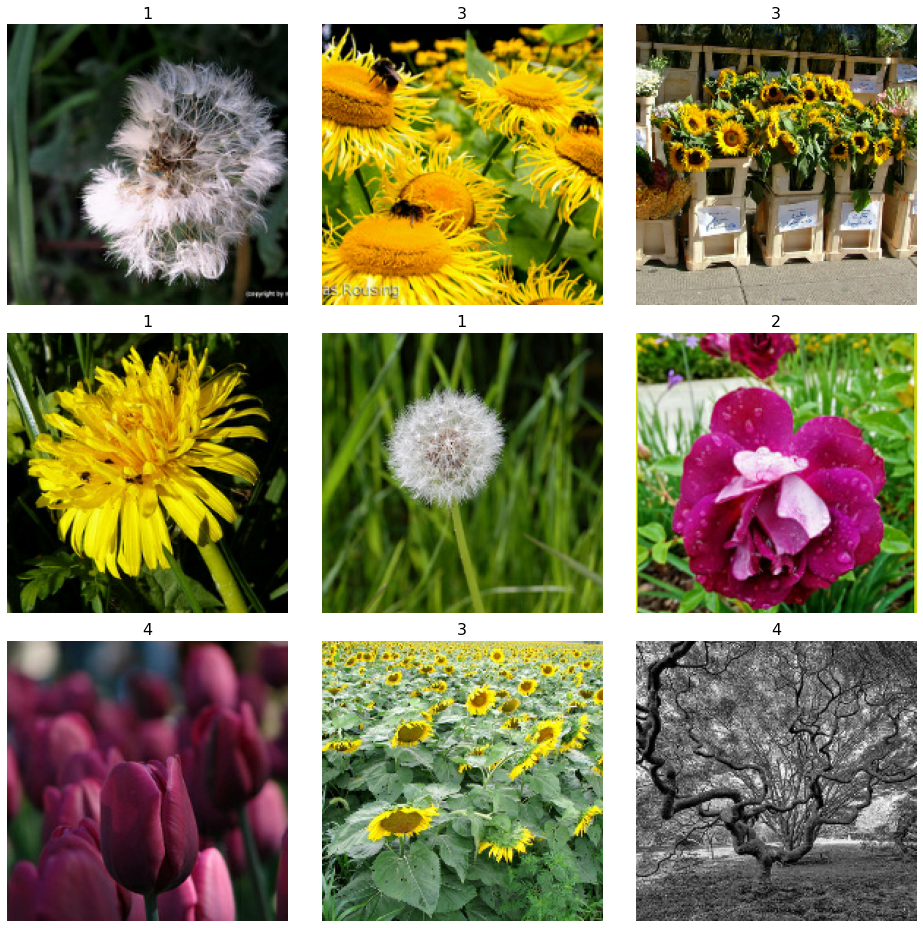

In [ ]:
### CODING TASK ###

# Reding TFRecord files, we will use the defined funtions from above
GCS_OUTPUT = 'gs://flowers-public/tfrecords-jpeg-192x192-2/' 

def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        "class": tf.io.FixedLenFeature([], tf.int64) #,   # shape [] means scalar
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [*TARGET_SIZE, 3])    
    class_num = example['class']
    return image, class_num 

def load_dataset(filenames):
    # read from TFRecords. For optimal performance, read from multiple    
    # TFRecord files at once and set the option experimental_deterministic = False
    # to allow order-altering optimizations.
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False

    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.map(read_tfrecord)
    return dataset

    
filenames = tf.io.gfile.glob(GCS_OUTPUT + "*.tfrec")
datasetTfrec = load_dataset(filenames) #( from now we will call datasetTfrec as secondary dataset which will be used in section 2 of this notebook and further)
display_9_images_from_dataset(datasetTfrec)

ii) Write your code it into a file using the *cell magic* `%%writefile spark_write_tfrec.py` at the beginning of the file. Then, run it locally in Spark. 



In [ ]:
### CODING TASK ###

# Combining all the work we did into a file which can be feeded into a cluster to check the performance.
%%writefile spark_write_tfrec.py
############################### Libraries #############################

import os, sys, math
import numpy as np
import time
import datetime
import string
import random
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
import pickle
import pyspark

############################### Predefined Variables #############################

PROJECT = 'airy-lodge-348916'
BUCKET = 'gs://{}-storage'.format(PROJECT)
GCS_PATTERN = 'gs://flowers-public/*/*.jpg' # glob  pattern for input files
PARTITIONS = 16 # no of partitions we will use later 
TARGET_SIZE = [192, 192] # target resolution for the images
CLASSES = [b'daisy', b'dandelion', b'roses', b'sunflowers', b'tulips']
sc = pyspark.SparkContext.getOrCreate()

############################### Predefined Functions #############################

def decode_jpeg_and_labels(filepath):
    # extracts the image data and creates a class label, based on the filepath 
    bits = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(bits)
    # parse flower name from containing directory
    label = tf.strings.split(tf.expand_dims(filepath, axis=-1), sep='/')
    label2 = label.values[-2]
    return image, label2

def resize_and_crop_images(x):
    image, label = x
    # Resizes and cropd using "fill" algorithm:
    # always make sure the resulting image is cut out from the source image 
    # so that it fills the TARGET_SIZE entirely with no black bars 
    # and a preserved aspect ratio.
    w = tf.shape(image)[0]
    h = tf.shape(image)[1]
    tw = TARGET_SIZE[1]
    th = TARGET_SIZE[0]
    resize_crit = (w * th) / (h * tw)
    image = tf.cond(resize_crit < 1,
                    lambda: tf.image.resize(image, [w*tw/w, h*tw/w]), # if true
                    lambda: tf.image.resize(image, [w*th/h, h*th/h])  # if false
                    )
    nw = tf.shape(image)[0]
    nh = tf.shape(image)[1]
    image = tf.image.crop_to_bounding_box(image, (nw - tw) // 2, (nh - th) // 2, tw, th)
    return image, label

def recompress_images(x):
    image, label = x
    # this reduces the amount of data, but takes some time
    image = tf.cast(image, tf.uint8)
    image = tf.image.encode_jpeg(image, optimize_size=True, chroma_downsampling=False)
    return image, label

############################### Tasks to perform #############################

#ii)
# Read the images and store it in a variable using the glob function.
path = tf.io.gfile.glob(GCS_PATTERN)

# Converting into a list
myRDD = sc.parallelize(path)

# iii) With our initial RDD named myRDD, we need to sample 2 percent of the total data without replacement. 
myRDD = myRDD.sample(False, 0.02)


# Using the functions defined above with the single argument, we will apply our mapping function to the RDD
RDD2 = myRDD.map(decode_jpeg_and_labels)
RDD3 = RDD2.map(resize_and_crop_images)
RDD4 = RDD3.map(recompress_images)

# Looking at the converted objects.
# RDD4.take(2) Display is not needed

GCS_OUTPUT = BUCKET + '/tfrecords-jpeg-192x192-2/'
def write_tfrecords(partition_index,partition_iterator):
  filepath = GCS_OUTPUT + "{}.tfrec".format(partition_index)
  with tf.io.TFRecordWriter(filepath) as out_file:
    for element in partition_iterator:
      image=element[0]
      label=element[1]
      example = to_tfrecord(out_file,
                            image.numpy(), 
                            label.numpy() 
                            )
      out_file.write(example.SerializeToString())
      return [filepath]
# v) Using our predefined function
RDD5 = RDD4.mapPartitionsWithIndex(write_tfrecords)
# RDD5.collect() Display is not needed

# 1b) Testing - this is just to display and store the data in a variable. 

Writing spark_write_tfrec.py


### 1c) Set up a cluster and run the script. (4%)

Following the example from the labs, set up a cluster to run PySpark jobs in the cloud. You need to set up so that TensorFlow is installed on all nodes in the cluster.  


#### i) Single machine cluster
Set up a cluster with a single machine using the maximal SSD size (100) and 8 vCPUs. 

Enable **package installation** by passing a flag `--initialization-actions` with argument `gs://goog-dataproc-initialization-actions-$REGION/python/pip-install.sh` (this is a public script that will read metadata to determine which packages to install). 
Then, the **packages are specified** by providing a `--metadata` flag with the argument `PIP_PACKAGES=tensorflow==2.4.0`. 

When the cluster is running, run your script to check that it works and keep the output cell output. (2%)


In [ ]:
### CODING TASK ###
# RUN-1
CLUSTER = '{}-cluster'.format(PROJECT)
!gcloud dataproc clusters create $CLUSTER \
    --image-version 1.4-ubuntu18 \
    --initialization-actions gs://goog-dataproc-initialization-actions-$REGION/python/pip-install.sh \
    --metadata PIP_PACKAGES=tensorflow==2.4.0\
    --master-machine-type n1-standard-8 \
    --master-boot-disk-type pd-ssd --master-boot-disk-size 100\
    --max-idle 3600s\

Waiting on operation [projects/airy-lodge-348916/regions/asia-southeast1/operations/425b98e7-ca21-3400-84ef-66cfb4d06043].
Created [https://dataproc.googleapis.com/v1/projects/airy-lodge-348916/regions/asia-southeast1/clusters/airy-lodge-348916-cluster] Cluster placed in zone [asia-southeast1-c].


Run the script in the cloud and test the output. 

In [ ]:
### CODING TASK ###
# This command with the run the task in cluster

!gcloud dataproc jobs submit pyspark --cluster $CLUSTER --region $REGION \spark_write_tfrec.py

Job [110f5ac7b0ff42728749ac3291a92827] submitted.
Waiting for job output...
2022-05-04 07:37:10.109578: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/hadoop/lib/native
2022-05-04 07:37:10.109621: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Tensorflow version 2.4.0
22/05/04 07:37:13 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
22/05/04 07:37:13 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
22/05/04 07:37:13 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator
22/05/04 07:37:13 INFO org.spark_project.jetty.util.log: Logging initialized @5276ms to org.spark_project.jetty.util.log.Slf4jLog
22/05/04 07:37:13 INFO org.spark_project.jetty.server.Server: jetty-9.4.z-SNAPSHOT; built

In [ ]:
# Deleting the cluster
# Once we finish our job, we will delete the cluster as we are using the credits which will be deducted if cluster is in running state.

!gcloud dataproc clusters delete $CLUSTER -q

Waiting on operation [projects/airy-lodge-348916/regions/asia-southeast1/operations/668cb3f6-f47c-39e6-a642-e4c931f2532e].
Deleted [https://dataproc.googleapis.com/v1/projects/airy-lodge-348916/regions/asia-southeast1/clusters/airy-lodge-348916-cluster].


In the free credit tier on Google Cloud, there are the following **restrictions** on compute machines:
- max 100GB of *SSD persistent disk*
- max 2000GB of *standard persistent disk* 
- max 8 *vCPU*s
- no GPUs

See [here](https://cloud.google.com/free/docs/gcp-free-tier#free-trial) for details 
The **disks are virtual** disks, where **I/O speed is limited in proportion to the size**, so we should allocate them evenly.
This has mainly an effect on the **time the cluster needs to start**, as we are reading the data mainly from the bucket and we are not writing much to disk at all.  


#### ii) Maximal cluster
Use the **largest possible cluster** within these constraints, i.e. **1 master and 7 worker nodes**. 
Each of them with 1 (virtual) CPU. 
The master should get the full *SSD* capacity and the 7 worker nodes should get equal shares of the *standard* disk capacity to maximise throughput. 

Once the cluster is running, test your script. (2%)

In [ ]:
### CODING TASK ###
# RUN-2
#Creating a cluster with only 1 master node and 7 worker nodes

CLUSTER = '{}-cluster'.format(PROJECT)
!gcloud dataproc clusters create $CLUSTER \
    --image-version 1.4-ubuntu18 \
    --initialization-actions gs://goog-dataproc-initialization-actions-$REGION/python/pip-install.sh \
    --metadata PIP_PACKAGES=tensorflow==2.4.0\
    --master-machine-type n1-standard-1 \
    --master-boot-disk-type pd-ssd --master-boot-disk-size 100\
    --num-workers 7 --worker-machine-type n1-standard-1 --worker-boot-disk-size 100\
    --max-idle 3600s\


Waiting on operation [projects/airy-lodge-348916/regions/asia-southeast1/operations/a38ceb88-3859-3243-8a7a-831fef30b209].

Created [https://dataproc.googleapis.com/v1/projects/airy-lodge-348916/regions/asia-southeast1/clusters/airy-lodge-348916-cluster] Cluster placed in zone [asia-southeast1-b].


In [ ]:
!gcloud dataproc jobs submit pyspark --cluster $CLUSTER --region $REGION \spark_write_tfrec.py

Job [5739fd3754664102a13fae5a0649578e] submitted.
Waiting for job output...
2022-05-04 07:46:20.512362: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/hadoop/lib/native
2022-05-04 07:46:20.512538: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Tensorflow version 2.4.0
22/05/04 07:46:24 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
22/05/04 07:46:24 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
22/05/04 07:46:25 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator
22/05/04 07:46:25 INFO org.spark_project.jetty.util.log: Logging initialized @9315ms to org.spark_project.jetty.util.log.Slf4jLog
22/05/04 07:46:25 INFO org.spark_project.jetty.server.Server: jetty-9.4.z-SNAPSHOT; built

In [ ]:
!gcloud dataproc clusters delete $CLUSTER -q

Waiting on operation [projects/airy-lodge-348916/regions/asia-southeast1/operations/dfcdd3e6-e7b1-3162-8e15-31faf37efbb3].
Deleted [https://dataproc.googleapis.com/v1/projects/airy-lodge-348916/regions/asia-southeast1/clusters/airy-lodge-348916-cluster].


### 1d)	Optimisation, experiments, and discussion (14%)

i) Improve parallelisation 

If you implemented a straightfoward version, you will 
**probably** observe that **all the computation** is done on only **two nodes**. 
This can be adressed by using the **second parameter** in the initial call to **parallelize**. 
Make the **suitable change** in the code you have written above and mark it up in comments as `### TASK 1d ###`. 

Demonstrate the difference in cluster utilisation before and after the change based on different parameter values with **screenshots from Google Cloud** and measure the **difference in the processing time**. (5%)

ii) Experiment with cluster configurations.

In addition to the experiments above (using 8 VMs),test your program with 4 machines with double the resources each (2 vCPUs, memory, disk) and 1 machine with eightfold resources. 
Discuss the results in terms of disk I/O and network bandwidth allocation in the cloud. (6%)

iii) Explain the difference between this use of Spark and most standard applications like e.g. in our labs in terms of where the data is stored. What kind of parallelisation approach is used here? (3%)

Write the code below and your answers in the report.


In [ ]:
# ### TASK 1d ###.
# The task is to perform the same operations as above, but while parellelising we need to add an argument which is user defined partitions to it. 
# Till now we are doing the partitions which are default. By default it takes 2 partitions.

# Combining all the work we did into a file which can be feeded into a cluster to check the performance.
%%writefile spark_write_tfrec_1d.py
############################### Libraries #############################

import os, sys, math
import numpy as np
import time
import datetime
import string
import random
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
import pickle
import pyspark

############################### Predefined Variables #############################

PROJECT = 'airy-lodge-348916'
BUCKET = 'gs://{}-storage'.format(PROJECT)
GCS_PATTERN = 'gs://flowers-public/*/*.jpg' # glob  pattern for input files
PARTITIONS = 16 # no of partitions we will use later 
TARGET_SIZE = [192, 192] # target resolution for the images
CLASSES = [b'daisy', b'dandelion', b'roses', b'sunflowers', b'tulips']
sc = pyspark.SparkContext.getOrCreate()

############################### Predefined Functions #############################

def decode_jpeg_and_labels(filepath):
    # extracts the image data and creates a class label, based on the filepath 
    bits = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(bits)
    # parse flower name from containing directory
    label = tf.strings.split(tf.expand_dims(filepath, axis=-1), sep='/')
    label2 = label.values[-2]
    return image, label2

def resize_and_crop_images(x):
    image, label = x
    # Resizes and cropd using "fill" algorithm:
    # always make sure the resulting image is cut out from the source image 
    # so that it fills the TARGET_SIZE entirely with no black bars 
    # and a preserved aspect ratio.
    w = tf.shape(image)[0]
    h = tf.shape(image)[1]
    tw = TARGET_SIZE[1]
    th = TARGET_SIZE[0]
    resize_crit = (w * th) / (h * tw)
    image = tf.cond(resize_crit < 1,
                    lambda: tf.image.resize(image, [w*tw/w, h*tw/w]), # if true
                    lambda: tf.image.resize(image, [w*th/h, h*th/h])  # if false
                    )
    nw = tf.shape(image)[0]
    nh = tf.shape(image)[1]
    image = tf.image.crop_to_bounding_box(image, (nw - tw) // 2, (nh - th) // 2, tw, th)
    return image, label

def recompress_images(x):
    image, label = x
    # this reduces the amount of data, but takes some time
    image = tf.cast(image, tf.uint8)
    image = tf.image.encode_jpeg(image, optimize_size=True, chroma_downsampling=False)
    return image, label

############################### Tasks to perform #############################

#ii)
# Read the images and store it in a variable using the glob function.
path = tf.io.gfile.glob(GCS_PATTERN)

# Converting into a list
myRDD = sc.parallelize(path,PARTITIONS)

# iii) With our initial RDD named myRDD, we need to sample 2 percent of the total data without replacement. 
myRDD = myRDD.sample(False, 0.02)


# Using the functions defined above with the single argument, we will apply our mapping function to the RDD
RDD2 = myRDD.map(decode_jpeg_and_labels)
RDD3 = RDD2.map(resize_and_crop_images)
RDD4 = RDD3.map(recompress_images)

# Looking at the converted objects.
# RDD4.take(2) Display is not needed

GCS_OUTPUT = BUCKET + '/tfrecords-jpeg-192x192-2/'
def write_tfrecords(partition_index,partition_iterator):
  filepath = GCS_OUTPUT + "{}.tfrec".format(partition_index)
  with tf.io.TFRecordWriter(filepath) as out_file:
    for element in partition_iterator:
      image=element[0]
      label=element[1]
      example = to_tfrecord(out_file,
                            image.numpy(), 
                            label.numpy() 
                            )
      out_file.write(example.SerializeToString())
      return [filepath]
# v) Using our predefined function
RDD5 = RDD4.mapPartitionsWithIndex(write_tfrecords)
# RDD5.collect() Display is not needed

Overwriting spark_write_tfrec_1d.py


In [ ]:
# RUN-3
CLUSTER = '{}-cluster'.format(PROJECT)
!gcloud dataproc clusters create $CLUSTER \
    --image-version 1.4-ubuntu18 \
    --initialization-actions gs://goog-dataproc-initialization-actions-$REGION/python/pip-install.sh \
    --metadata PIP_PACKAGES=tensorflow==2.4.0\
    --master-machine-type n1-standard-8 \
    --master-boot-disk-type pd-ssd --master-boot-disk-size 100\
    --max-idle 3600s\

Waiting on operation [projects/airy-lodge-348916/regions/asia-southeast1/operations/ec273e5e-6cd1-3665-a555-a41b451f20ae].
Created [https://dataproc.googleapis.com/v1/projects/airy-lodge-348916/regions/asia-southeast1/clusters/airy-lodge-348916-cluster] Cluster placed in zone [asia-southeast1-c].


In [ ]:
# On the same cluster we will run multiple times the same file with the change in Partition size to check which partition works better

# RUN-3 checks the performance with 4 partitions
# RUN-4 checks the performance with 8 partitions
# RUN-5 checks the performance with 16 partitions

!gcloud dataproc jobs submit pyspark --cluster $CLUSTER --region $REGION \spark_write_tfrec_1d.py

Job [dcb08410b0bd4bb49e66a7f3431eff38] submitted.
Waiting for job output...
2022-05-04 08:11:36.620532: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/hadoop/lib/native
2022-05-04 08:11:36.620578: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Tensorflow version 2.4.0
22/05/04 08:11:38 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
22/05/04 08:11:38 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
22/05/04 08:11:39 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator
22/05/04 08:11:39 INFO org.spark_project.jetty.util.log: Logging initialized @4202ms to org.spark_project.jetty.util.log.Slf4jLog
22/05/04 08:11:39 INFO org.spark_project.jetty.server.Server: jetty-9.4.z-SNAPSHOT; built

In [ ]:
!gcloud dataproc clusters delete $CLUSTER -q

Waiting on operation [projects/airy-lodge-348916/regions/asia-southeast1/operations/690d0d58-2896-3de6-98a9-ee604fe21cbc].
Deleted [https://dataproc.googleapis.com/v1/projects/airy-lodge-348916/regions/asia-southeast1/clusters/airy-lodge-348916-cluster].


In [ ]:
# Task 1d
# ii) Experiment with cluster configurations.

# In addition to the experiments above (using 8 VMs),test your program with 4 machines with double the resources each (2 vCPUs, memory, disk) and 1 machine with eightfold resources. Discuss the results in terms of disk I/O and network bandwidth allocation in the cloud. (6%)

# Creating a cluster with 2 Master's and in the workers, we have 3 workers. Where we divide all the workers also into the n1-standard-2 where we alot disk size of 100 each.
# RUN-6
CLUSTER = '{}-cluster'.format(PROJECT)
!gcloud dataproc clusters create $CLUSTER \
    --image-version 1.4-ubuntu18 \
    --initialization-actions gs://goog-dataproc-initialization-actions-$REGION/python/pip-install.sh \
    --metadata PIP_PACKAGES=tensorflow==2.4.0\
    --master-machine-type n1-standard-2 \
    --master-boot-disk-type pd-ssd --master-boot-disk-size 100\
    --num-workers 3 --worker-machine-type n1-standard-2 --worker-boot-disk-size 100\
    --max-idle 3600s

Waiting on operation [projects/airy-lodge-348916/regions/asia-southeast1/operations/218d1a87-1cb9-31df-97bc-1bae1cee1ba8].

Created [https://dataproc.googleapis.com/v1/projects/airy-lodge-348916/regions/asia-southeast1/clusters/airy-lodge-348916-cluster] Cluster placed in zone [asia-southeast1-b].


In [ ]:
!gcloud dataproc jobs submit pyspark --cluster $CLUSTER --region $REGION \spark_write_tfrec_1d.py

Job [8ca3cd75a80f466287126903422cd64a] submitted.
Waiting for job output...
2022-05-04 08:18:34.492729: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/hadoop/lib/native
2022-05-04 08:18:34.492796: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Tensorflow version 2.4.0
22/05/04 08:18:38 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
22/05/04 08:18:38 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
22/05/04 08:18:38 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator
22/05/04 08:18:38 INFO org.spark_project.jetty.util.log: Logging initialized @6846ms to org.spark_project.jetty.util.log.Slf4jLog
22/05/04 08:18:38 INFO org.spark_project.jetty.server.Server: jetty-9.4.z-SNAPSHOT; built

In [ ]:
!gcloud dataproc clusters delete $CLUSTER -q

Waiting on operation [projects/airy-lodge-348916/regions/asia-southeast1/operations/f6487aa0-a1f3-36b8-a16a-c7c0dee729a4].
Deleted [https://dataproc.googleapis.com/v1/projects/airy-lodge-348916/regions/asia-southeast1/clusters/airy-lodge-348916-cluster].


In [ ]:
# RUN-7
# 1 machine with eightfold resources
CLUSTER = '{}-cluster'.format(PROJECT)
!gcloud dataproc clusters create $CLUSTER \
    --image-version 1.4-ubuntu18 --single-node \
    --initialization-actions gs://goog-dataproc-initialization-actions-$REGION/python/pip-install.sh \
    --metadata PIP_PACKAGES=tensorflow==2.4.0\
    --master-machine-type n1-standard-8 \
    --master-boot-disk-type pd-ssd --master-boot-disk-size 100\
    --max-idle 3600s

Waiting on operation [projects/airy-lodge-348916/regions/asia-southeast1/operations/40893e2a-e903-30d5-aaab-2aca67e69612].
Created [https://dataproc.googleapis.com/v1/projects/airy-lodge-348916/regions/asia-southeast1/clusters/airy-lodge-348916-cluster] Cluster placed in zone [asia-southeast1-b].


In [ ]:
!gcloud dataproc jobs submit pyspark --cluster $CLUSTER --region $REGION \spark_write_tfrec_1d.py

Job [5a00dd530d55403282df14f0c279bc75] submitted.
Waiting for job output...
2022-05-04 08:25:32.397002: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/hadoop/lib/native
2022-05-04 08:25:32.397045: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Tensorflow version 2.4.0
22/05/04 08:25:35 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
22/05/04 08:25:35 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
22/05/04 08:25:36 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator
22/05/04 08:25:36 INFO org.spark_project.jetty.util.log: Logging initialized @6027ms to org.spark_project.jetty.util.log.Slf4jLog
22/05/04 08:25:36 INFO org.spark_project.jetty.server.Server: jetty-9.4.z-SNAPSHOT; built

In [ ]:
!gcloud dataproc clusters delete $CLUSTER -q

Waiting on operation [projects/airy-lodge-348916/regions/asia-southeast1/operations/7f4d9487-38a8-36f5-bcf0-8358aa41ab74].
Deleted [https://dataproc.googleapis.com/v1/projects/airy-lodge-348916/regions/asia-southeast1/clusters/airy-lodge-348916-cluster].


# Section 2: Speed tests

We have seen that **reading from the pre-processed TFRecord files** is **faster** than reading individual image files and decoding on the fly. 
This task is about **measuring this effect** and **parallelizing the tests with PySpark**. 

## 2.1 Speed test implementation 

Here is **code for time measurement** to determine the **throughput in images per second**. 
It doesn't render the images but extracts and prints some basic information in order to make sure the image data are read. 
We write the information to the null device for longer measurements `null_file=open("/dev/null", mode='w')`. 
That way it will not clutter our cell output.

We use batches ( `dset2 = dset1.batch(batch_size)` ) and select a number of batches with (`dset3 = dset2.take(batch_number)`). 
Then we  use the `time.time()` to take the **time measurement** and take it multiple times, reading from the same dataset to see if reading speed changes with mutiple readings. 

We then **vary** the size of the batch (`batch_size`) and the number of batches (`batch_number`) and **store the results for different values**. 
Store also the **results for each repetition** over the same dataset (repeat 2 or 3 times).

The speed test should be combined in a **function** `time_configs()` that takes a configuration, i.e. a dataset and arrays of `batch_sizes`, `batch_numbers`, and  `repetitions` (an array of integers starting from 1), as **arguments** and runs the time measurement for each combination of batch_size and batch_number for the requested number of repetitions. 

In [ ]:
# Here are some useful values for testing your code, use higher values later for actually testing throughput
batch_sizes = [2,4] 
batch_numbers = [3,6] 
repetitions = [1]

def time_configs(dataset, batch_sizes, batch_numbers, repetitions): 
    dims = [len(batch_sizes),len(batch_numbers),len(repetitions)] 
    print(dims) 
    results = np.zeros(dims) 
    params = np.zeros(dims + [3]) 
    print( results.shape ) 
    with open("/dev/null",mode='w') as null_file: # for printing the output without showing it
        tt = time.time() # for overall time taking 
        for bsi,bs in enumerate(batch_sizes): 
            for dsi, ds in enumerate(batch_numbers): 
                batched_dataset = dataset.batch(bs)  
                timing_set = batched_dataset.take(ds) 
                for ri,rep in enumerate(repetitions): 
                    print("bs: {}, ds: {}, rep: {}".format(bs,ds,rep)) 
                    t0 = time.time() 
                    for image, label in timing_set: 
                        #print("Image batch shape {}".format(image.numpy().shape),
                        print("Image batch shape {}, {})".format(image.numpy().shape, 
                            [str(lbl) for lbl in label.numpy()]), null_file)
                    td = time.time() - t0 # duration for reading images
                    results[bsi,dsi,ri] = ( bs * ds) / td 
                    params[bsi,dsi,ri] = [ bs, ds, rep ]
    print("total time: "+str(time.time()-tt))
    return results, params

**Let's try this function** with a **small number** of configurations of batch_sizes batch_numbers and repetions, so that we get a set of parameter combinations and corresponding reading speeds.
Try reading from the image files (dataset2) and the TFRecord files (datasetDecoded). 

In [ ]:
# ### CODING TASK
# [res,par] = time_configs(dataset2, batch_sizes, batch_numbers, repetitions)
# print(res) 
# print(par) 

# print("=============")

# [res,par] = time_configs(datasetDecoded, batch_sizes, batch_numbers, repetitions)
# print(res)
# print(par)

## Task 2: Parallelising the speed test with Spark in the cloud. (30%)

As an exercise in **Spark programming and optimisation** as well as **performance analysis**, we will now implement the **speed test** with multiple parameters in parallel with Spark. 
Runing multiple tests in parallel would **not be a useful approach on a single machine, but it can be in the cloud** (you will be asked to reason about this later). 


### 2a) Create the script (12%)
Your task is now to **port the speed test above to Spark** for running it in the cloud in Dataproc. 
**Adapt the speed testing** as a Spark program that performs the same actions as above, but **with Spark RDDs in a distributed way**. 
The distribution should be such that **each parameter combination (except repetition)** is processed in a separate Spark task.

More specifically: 
*   i) combine the previous cells to have the code to create a dataset and create a list of parameter combinations in an RDD (2%)
*   ii) get a Spark context and  create the dataset and run timing test for each combination in parallel (2%)
*   iii) transform the resulting RDD to the structure \( parameter_combination, images_per_second \) and save these values in an array (2%)
*   iv) create an RDD with all results for each parameter as (parameter_value,images_per_second) and collect the result for each parameter  (1%)
*   v) create an RDD with the average reading speeds for each parameter value and collect the results. Keep associativity in mind when implementing the average. (3%) 
*   vi) write the results to a pickle file in your bucket (1%)
*   vii) Write your code it into a file using the *cell magic* `%%writefile spark_job.py` (1%)


**Important:** The task here is not to parallelize the pre-processing, but to run multiple speed tests in parallel using Spark.


In [ ]:
### CODING TASK
# The given task is to modify the above given function where it takes all the images with batch_size and batch_number and iterates in the loop of repetitions. The goal is to check the speed by calculating the time before and after. 
def time_configs(ds,bs,bn,rep):
  t0=time.time()
  batch1 = ds.batch(bs)
  take1 = batch1.take(bn)
  for i in range(rep):
    for image in take1:
      print('string', file=open("/dev/null", mode='w'))
  t1=time.time()
  all_images=bs*bn*rep
  throughput=all_images/(t1-t0)
  return throughput


In [ ]:
# Modifying the values and checking the throughput
batch_sizes = [2,4,8] 
batch_numbers = [3,6,9] 
repetitions = [1,2]


# Actually dataset2 hasn't been defined till now but just used as a notation in write_tfrecords function. 
# We can create dataset2 by uncommenting the given cell with function write_tfrecords but I prefer to define it seperately so the clarity is maintained
# Hence we will first create the dataset and then use it
# This code is taken from the initial function.
filenames_rr = tf.data.Dataset.list_files(GCS_PATTERN) 
dataset1_rr = filenames_rr.map(decode_jpeg_and_label)
dataset2 = dataset1_rr.map(resize_and_crop_image, num_parallel_calls = tf.data.experimental.AUTOTUNE) #(from now we will call dataset2 as primary dataset)
# Second argument solves the issue of being a tensor where we need later


# Creating an empty dataframe
import pandas as pd;
columns=['name','batch_size', 'batch_number', 'repetition','dataset_size','speed']
df = pd.DataFrame(columns=columns) 

# Reading out values into the dataframe while calculating the speeds using the above function we defined
for bs in batch_sizes:
  for bn in batch_numbers:
    for rep in repetitions:
      dataset_size=bs*bn
      data1=time_configs(dataset2,bs,bn,rep)
      df=df.append({'name': 'dataset2', 'batch_size': bs, 'batch_number': bn,'repetition': rep,'dataset_size': dataset_size,'speed': data1}, ignore_index=True)
      data2=time_configs(datasetTfrec,bs,bn,rep)
      df=df.append({'name': 'datasetTfrec', 'batch_size': bs, 'batch_number': bn,'repetition': rep,'dataset_size': dataset_size,'speed': data2}, ignore_index=True)
df

name batch_size batch_number repetition dataset_size       speed
0       dataset2          2            3          1            6   11.890673
1   datasetTfrec          2            3          1            6   27.224662
2       dataset2          2            3          2            6    9.347048
3   datasetTfrec          2            3          2            6   28.289016
4       dataset2          2            6          1           12   12.209799
5   datasetTfrec          2            6          1           12   89.463535
6       dataset2          2            6          2           12   14.558572
7   datasetTfrec          2            6          2           12   74.759835
8       dataset2          2            9          1           18   15.334872
9   datasetTfrec          2            9          1           18  136.564946
10      dataset2          2            9          2           18   14.803885
11  datasetTfrec          2            9          2           18  118.109669
12      dataset2          4            3          1           12   13.720297
13  datasetTfrec          4            3          1           12   74.505800
14      dataset2          4            3          2           12   15.652539
15  datasetTfrec          4            3          2           12   79.919540
16      dataset2          4            6          1           24   16.054145
17  datasetTfrec          4            6          1           24  149.081336
18      dataset2          4            6          2           24   17.579827
19  datasetTfrec          4            6          2           24  170.830742
20      dataset2          4            9          1           36   18.769533
21  datasetTfrec          4            9          1           36  240.238121
22      dataset2          4            9          2           36   20.496619
23  datasetTfrec          4            9          2           36  221.553869
24      dataset2          8            3          1           24   16.289155
25  datasetTfrec          8            3          1           24  148.510585
26      dataset2          8            3          2           24   17.287648
27  datasetTfrec          8            3          2           24  170.615611
28      dataset2          8            6          1           48   20.657784
29  datasetTfrec          8            6          1           48  322.088535
30      dataset2          8            6          2           48   19.894744
31  datasetTfrec          8            6          2           48  326.587654
32      dataset2          8            9          1           72   19.583374
33  datasetTfrec          8            9          1           72  367.976098
34      dataset2          8            9          2           72   20.813413
35  datasetTfrec          8            9          2           72  385.599654

In [ ]:
# i) combine the previous cells to have the code to create a dataset and create a list of parameter combinations in an RDD (2%)
# ii) get a Spark context and create the dataset and run timing test for each combination in parallel (2%)

import pyspark
from pyspark.sql import SQLContext
from pyspark.sql import Row

SC = pyspark.SparkContext.getOrCreate()
spark_context = SQLContext(SC)

# Removing the last column as we need to calculate the timing for the RDD
params = df.iloc[:,:-1]

spark_params = spark_context.createDataFrame(params)
# Converting into an RDD
spark_params_rdd=spark_params.rdd
 ### TASK 3b ###.
#spark_params_rdd.cache()

# Now that we have the RDD, we need to calculate the speeds using the above function on both the datasets which are Primary Dataset and Secondary Dataset. 
# First we will copy the functions which were defined earlier so that we can use it.



# #We will adapt the time_configs functions that it takes the parameter of RDD and returns the time.
def rdd_time_configs(rdd_params):
  t0=time.time()
  # As we have two kinds of images, we will read them seperately using the for loop
  if (rdd_params['name']=='datasetTfrec'):
    dataset = load_dataset(filenames)
  else:
    filename = tf.data.Dataset.list_files(GCS_PATTERN) 
    dataset3 = filename.map(decode_jpeg_and_label)
    dataset = dataset3.map(resize_and_crop_image)  
 
  dataset4 = dataset.batch(rdd_params['batch_size'])
  dataset5 = dataset4.take(rdd_params['batch_number'])
  for i in range(rdd_params['repetition']):
    for image in dataset5:
      print('string', file=open("/dev/null", mode='w'))
  t1=time.time()
  all_images=rdd_params['batch_size']*rdd_params['batch_number']*rdd_params['repetition']
  throughput=all_images/(t1-t0);
  return throughput

In [ ]:
speed_params_rdd=spark_params_rdd.map(lambda row: Row(name=str(row['name']),batch_size=int(row['batch_size']),batch_number=int(row['batch_number']),repetition=int(row['repetition']),dataset_size=int(row['dataset_size']),img_speed=float(rdd_time_configs(row))))
speed_params_rdd.take(7)


[Row(batch_number=3, batch_size=2, dataset_size=6, img_speed=4.575291580066526, name='dataset2', repetition=1),
 Row(batch_number=3, batch_size=2, dataset_size=6, img_speed=20.6063750343906, name='datasetTfrec', repetition=1),
 Row(batch_number=3, batch_size=2, dataset_size=6, img_speed=6.507728142836917, name='dataset2', repetition=2),
 Row(batch_number=3, batch_size=2, dataset_size=6, img_speed=28.767944653955762, name='datasetTfrec', repetition=2),
 Row(batch_number=6, batch_size=2, dataset_size=12, img_speed=8.181821994546823, name='dataset2', repetition=1),
 Row(batch_number=6, batch_size=2, dataset_size=12, img_speed=65.70874212284639, name='datasetTfrec', repetition=1),
 Row(batch_number=6, batch_size=2, dataset_size=12, img_speed=10.355522051005192, name='dataset2', repetition=2)]

In [ ]:
# iii) transform the resulting RDD to the structure ( parameter_combination, images_per_second ) and save these values in an array (2%)

combi_array=speed_params_rdd.map(np.array)
combi_array.take(8)

[array(['3', '2', '6', '4.489282801463353', 'dataset2', '1'], dtype='<U32'),
 array(['3', '2', '6', '33.25170844630484', 'datasetTfrec', '1'],
       dtype='<U32'),
 array(['3', '2', '6', '7.911953669820603', 'dataset2', '2'], dtype='<U32'),
 array(['3', '2', '6', '43.347648296983245', 'datasetTfrec', '2'],
       dtype='<U32'),
 array(['6', '2', '12', '7.91437719916327', 'dataset2', '1'], dtype='<U32'),
 array(['6', '2', '12', '72.96778823362266', 'datasetTfrec', '1'],
       dtype='<U32'),
 array(['6', '2', '12', '8.389589581981092', 'dataset2', '2'], dtype='<U32'),
 array(['6', '2', '12', '72.66256037269923', 'datasetTfrec', '2'],
       dtype='<U32')]

In [ ]:
# iv) create an RDD with all results for each parameter as (parameter_value,images_per_second) and collect the result for each parameter (1%)

# First we have two types of datasets which are Primary and Secondary datasets.

# Lets us differentiate the datasets first and then we will create an RDD as per the parameter.
img_file=speed_params_rdd.filter(lambda row: row['name']=='dataset2')

tf_file=speed_params_rdd.filter(lambda row: row['name']=='datasetTfrec')
tf_file.take(7)

[Row(batch_number=3, batch_size=2, dataset_size=6, img_speed=31.425422477962965, name='datasetTfrec', repetition=1),
 Row(batch_number=3, batch_size=2, dataset_size=6, img_speed=35.68858562817441, name='datasetTfrec', repetition=2),
 Row(batch_number=6, batch_size=2, dataset_size=12, img_speed=67.77623398396209, name='datasetTfrec', repetition=1),
 Row(batch_number=6, batch_size=2, dataset_size=12, img_speed=79.77222629021368, name='datasetTfrec', repetition=2),
 Row(batch_number=9, batch_size=2, dataset_size=18, img_speed=113.25362611251037, name='datasetTfrec', repetition=1),
 Row(batch_number=9, batch_size=2, dataset_size=18, img_speed=113.82254847419911, name='datasetTfrec', repetition=2),
 Row(batch_number=3, batch_size=4, dataset_size=12, img_speed=75.4036698347256, name='datasetTfrec', repetition=1)]

In [ ]:
# From the above result we can see that the img_speed is not the last in the list
# Now for each of the parameters, we will create an RDD along with the img_speed

img_file_bs=img_file.map(lambda row: Row(batch_size=int(row['batch_size']),img_speed=float(row['img_speed'])))
img_bs = img_file_bs.collect()
img_file_bn=img_file.map(lambda row: Row(batch_number=int(row['batch_number']),img_speed=float(row['img_speed'])))
img_bn = img_file_bn.collect()
img_file_ds=img_file.map(lambda row: Row(dataset_size=int(row['dataset_size']),img_speed=float(row['img_speed'])))
img_ds = img_file_ds.collect()
# The repetition and the img_speed values are in reverse order. 
# Hence we will collect them after reversing the values.
img_file_rep=img_file.map(lambda row: Row(repetition=int(row['repetition']),img_speed=float(row['img_speed'])))
img_file_rep = img_file_rep.map(lambda x: (x[1],x[0]))
img_rep = img_file_rep.collect()

# Let's start doing the similar pattern for tf_files(Secondary files)

tf_file_bs=tf_file.map(lambda row: Row(batch_size=int(row['batch_size']),img_speed=float(row['img_speed'])))
tf_bs = tf_file_bs.collect()
tf_file_bn=tf_file.map(lambda row: Row(batch_number=int(row['batch_number']),img_speed=float(row['img_speed'])))
tf_bn = tf_file_bn.collect()
tf_file_ds=tf_file.map(lambda row: Row(dataset_size=int(row['dataset_size']),img_speed=float(row['img_speed'])))
tf_ds = tf_file_ds.collect()
tf_file_rep=tf_file.map(lambda row: Row(repetition=int(row['repetition']),img_speed=float(row['img_speed'])))
tf_file_rep = tf_file_rep.map(lambda x: (x[1],x[0]))
tf_rep = tf_file_rep.collect()

In [ ]:
# Checking everything is correct
img_file_rep.take(8)

[(1, 5.05729924344959),
 (2, 7.631962516205827),
 (1, 8.083652220000483),
 (2, 10.522433970648326),
 (1, 11.756264391200538),
 (2, 14.279085271973198),
 (1, 8.941091452486308),
 (2, 11.852027117718118)]

In [ ]:
# v) create an RDD with the average reading speeds for each parameter value and collect the results. Keep associativity in mind when implementing the average. (3%)

# For this task lets create an average function 
def avg_map_func(row):
    return (row[0], (row[1], 1))

# We will create one more function for average which can combine the values maintaning the associativity.
def avg_reduce_func(value1, value2):
    return ((value1[0] + value2[0], value1[1] + value2[1])) 


# This functions has been implemented using the reference https://stackoverflow.com/questions/57030626/how-to-use-pyspark-to-calculate-average-on-rdd

# Primary files

img_file_bs_avg=img_file_bs.map(avg_map_func).reduceByKey(avg_reduce_func).mapValues(lambda x: x[0]/x[1])
img_bs_avg = img_file_bs_avg.collect()
img_file_bn_avg=img_file_bn.map(avg_map_func).reduceByKey(avg_reduce_func).mapValues(lambda x: x[0]/x[1])
img_bn_avg = img_file_bn_avg.collect()
img_file_ds_avg=img_file_ds.map(avg_map_func).reduceByKey(avg_reduce_func).mapValues(lambda x: x[0]/x[1])
img_ds_avg = img_file_ds_avg.collect()
img_file_rep_avg=img_file_rep.map(avg_map_func).reduceByKey(avg_reduce_func).mapValues(lambda x: x[0]/x[1])
img_rep_avg = img_file_rep_avg.collect()

# Secondary files
tf_file_bs_avg=tf_file_bs.map(avg_map_func).reduceByKey(avg_reduce_func).mapValues(lambda x: x[0]/x[1])
tf_bs_avg = tf_file_bs_avg.collect()
tf_file_bn_avg=tf_file_bn.map(avg_map_func).reduceByKey(avg_reduce_func).mapValues(lambda x: x[0]/x[1])
tf_bn_avg = tf_file_bn_avg.collect()
tf_file_ds_avg=tf_file_ds.map(avg_map_func).reduceByKey(avg_reduce_func).mapValues(lambda x: x[0]/x[1])
tf_ds_avg = tf_file_ds_avg.collect()
tf_file_rep_avg=tf_file_rep.map(avg_map_func).reduceByKey(avg_reduce_func).mapValues(lambda x: x[0]/x[1])
tf_rep_avg = tf_file_rep_avg.collect()


# Lets check if this worked well
tf_file_rep_avg.take(6)

[(2, 159.41702146755094), (1, 149.32043650905806)]

In [ ]:
# vi) write the results to a pickle file in your bucket (1%)
# From the lab Lab 4a part3: 'Connecting to the Google Cloud from Colab' we are using the save function. 

# https://colab.research.google.com/drive/1jZdnYNez89vAEJzeWrjcKS2gd7-R_U3C

def save(object,bucket,filename):
    with open(filename,mode='wb') as f:
        pickle.dump(object,f)
    print("Saving {} to {}".format(filename,bucket))
    import subprocess
    proc = subprocess.run(["gsutil","cp", filename, bucket],stderr=subprocess.PIPE)
    print("gstuil returned: " + str(proc.returncode))
    print(str(proc.stderr))


# Here the task is not to save but to dump the pickel files in our bucket. We will use the methodology from the above function and we will implement it further.

my_file = 'Task2a.pkl'
with open(my_file, mode= 'wb') as f:
      pickle.dump(img_bs,f)
      pickle.dump(img_bn,f)
      pickle.dump(img_ds,f)
      pickle.dump(img_rep,f)
      pickle.dump(tf_bs,f)
      pickle.dump(tf_bn,f)
      pickle.dump(tf_ds,f)
      pickle.dump(tf_rep,f)
      pickle.dump(img_bs_avg,f)
      pickle.dump(img_bn_avg,f)
      pickle.dump(img_ds_avg,f)
      pickle.dump(img_rep_avg,f)
      pickle.dump(tf_bs_avg,f)
      pickle.dump(tf_bn_avg,f)
      pickle.dump(tf_ds_avg,f)
      pickle.dump(tf_rep_avg,f)
print("Saving {} to {}".format(my_file,BUCKET))
import subprocess
proc = subprocess.run(["gsutil","cp", my_file, BUCKET],stderr=subprocess.PIPE)
print("gstuil returned: " + str(proc.returncode))
print(str(proc.stderr))

Saving Task2a.pkl to gs://airy-lodge-348916-storage
gstuil returned: 0
b'Copying file://Task2a.pkl [Content-Type=application/octet-stream]...\n/ [0 files][    0.0 B/  5.9 KiB]                                                \r/ [1 files][  5.9 KiB/  5.9 KiB]                                                \r\nOperation completed over 1 objects/5.9 KiB.                                      \n'


### 2b) Testing the code and collecting results (3%)

i) First, test locally with `%run`.

It is useful to create a **new filename argument**, so that old results don't get overwritten. 

You can for instance use `datetime.datetime.now().strftime("%y%m%d-%H%M")` to get a string with the current date and time and use that in the file name.

In [ ]:
### CODING TASK ###
# Let's combine all the work and write it into a file
%%writefile task2.py

############################### Libraries  #############################

import pyspark
from pyspark.sql import SQLContext
from pyspark.sql import Row
import os, sys, math
import numpy as np
import time
import datetime
import string
import random
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
import pickle

############################### Predefined Variables #############################

PROJECT = 'airy-lodge-348916'
BUCKET = 'gs://{}-storage'.format(PROJECT)
GCS_PATTERN = 'gs://flowers-public/*/*.jpg' # glob  pattern for input files
PARTITIONS = 16 # no of partitions we will use later 
TARGET_SIZE = [192, 192] # target resolution for the images
CLASSES = [b'daisy', b'dandelion', b'roses', b'sunflowers', b'tulips']

GCS_OUTPUT = 'gs://flowers-public/tfrecords-jpeg-192x192-2/' 

batch_sizes = [2,4,8] 
batch_numbers = [3,6,9] 
repetitions = [1,2]

############################### Pre defined functions #############################

def decode_jpeg_and_label(filepath):
    # extracts the image data and creates a class label, based on the filepath 
    bits = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(bits)
    # parse flower name from containing directory
    label = tf.strings.split(tf.expand_dims(filepath, axis=-1), sep='/')
    label2 = label.values[-2]
    return image, label2

def resize_and_crop_image(image, label):
    # Resizes and cropd using "fill" algorithm:
    # always make sure the resulting image is cut out from the source image 
    # so that it fills the TARGET_SIZE entirely with no black bars 
    # and a preserved aspect ratio.
    w = tf.shape(image)[0]
    h = tf.shape(image)[1]
    tw = TARGET_SIZE[1]
    th = TARGET_SIZE[0]
    resize_crit = (w * th) / (h * tw)
    image = tf.cond(resize_crit < 1,
                    lambda: tf.image.resize(image, [w*tw/w, h*tw/w]), # if true
                    lambda: tf.image.resize(image, [w*th/h, h*th/h])  # if false
                    )
    nw = tf.shape(image)[0]
    nh = tf.shape(image)[1]
    image = tf.image.crop_to_bounding_box(image, (nw - tw) // 2, (nh - th) // 2, tw, th)
    return image, label

def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        "class": tf.io.FixedLenFeature([], tf.int64) #,   # shape [] means scalar
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [*TARGET_SIZE, 3])    
    class_num = example['class']
    return image, class_num 

def load_dataset(filenames):
    # read from TFRecords. For optimal performance, read from multiple    
    # TFRecord files at once and set the option experimental_deterministic = False
    # to allow order-altering optimizations.
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False

    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.map(read_tfrecord)
    return dataset

    
filenames = tf.io.gfile.glob(GCS_OUTPUT + "*.tfrec")
datasetTfrec = load_dataset(filenames) 


# The given task is to modify the above given function where it takes all the images with batch_size and batch_number and iterates in the loop of repetitions. The goal is to check the speed by calculating the time before and after. 
def time_configs(ds,bs,bn,rep):
  t0=time.time()
  batch1 = ds.batch(bs)
  take1 = batch1.take(bn)
  for i in range(rep):
    for image in take1:
      print('string', file=open("/dev/null", mode='w'))
  t1=time.time()
  all_images=bs*bn*rep
  throughput=all_images/(t1-t0)
  return throughput


# We will adapt the time_configs functions that it takes the parameter of RDD and returns the time.
def rdd_time_configs(rdd_params):
  t0=time.time()
  # As we have two kinds of images, we will read them seperately using the for loop
  if (rdd_params['name']=='datasetTfrec'):
    dataset = load_dataset(filenames)
  else:
    filename = tf.data.Dataset.list_files(GCS_PATTERN) 
    dataset3 = filename.map(decode_jpeg_and_label)
    dataset = dataset3.map(resize_and_crop_image)  
 
  dataset4 = dataset.batch(rdd_params['batch_size'])
  dataset5 = dataset4.take(rdd_params['batch_number'])
  for i in range(rdd_params['repetition']):
    for image in dataset5:
      print('string', file=open("/dev/null", mode='w'))
  t1=time.time()
  all_images=rdd_params['batch_size']*rdd_params['batch_number']*rdd_params['repetition']
  throughput=all_images/(t1-t0);
  return throughput

def avg_map_func(row):
    return (row[0], (row[1], 1))

# We will create one more function for average which can combine the values maintaning the associativity.
def avg_reduce_func(value1, value2):
    return ((value1[0] + value2[0], value1[1] + value2[1])) 
############################### Tasks to perform #############################

# Actually dataset2 hasn't been defined till now but just used as a notation in write_tfrecords function. 
# We can create dataset2 by uncommenting the given cell with function write_tfrecords but I prefer to define it seperately so the clarity is maintained
# Hence we will first create the dataset and then use it
# This code is taken from the initial function.
filenames_rr = tf.data.Dataset.list_files(GCS_PATTERN) 
dataset1_rr = filenames_rr.map(decode_jpeg_and_label)
dataset2 = dataset1_rr.map(resize_and_crop_image, num_parallel_calls = tf.data.experimental.AUTOTUNE) #(from now we will call dataset2 as primary dataset)
# Second argument solves the issue of being a tensor where we need later

# Creating an empty dataframe
import pandas as pd;
columns=['name','batch_size', 'batch_number', 'repetition','dataset_size','speed']
df = pd.DataFrame(columns=columns) 

# Reading out values into the dataframe while calculating the speeds using the above function we defined
for bs in batch_sizes:
  for bn in batch_numbers:
    for rep in repetitions:
      dataset_size=bs*bn
      data1=time_configs(dataset2,bs,bn,rep)
      df=df.append({'name': 'dataset2', 'batch_size': bs, 'batch_number': bn,'repetition': rep,'dataset_size': dataset_size,'speed': data1}, ignore_index=True)
      data2=time_configs(datasetTfrec,bs,bn,rep)
      df=df.append({'name': 'datasetTfrec', 'batch_size': bs, 'batch_number': bn,'repetition': rep,'dataset_size': dataset_size,'speed': data2}, ignore_index=True)

# i) combine the previous cells to have the code to create a dataset and create a list of parameter combinations in an RDD (2%)
# ii) get a Spark context and create the dataset and run timing test for each combination in parallel (2%)

SC = pyspark.SparkContext.getOrCreate()
spark_context = SQLContext(SC)

# Removing the last column as we need to calculate the timing for the RDD
params = df.iloc[:,:-1]

spark_params = spark_context.createDataFrame(params)
# Converting into an RDD
spark_params_rdd=spark_params.rdd
 ### TASK 3b ###.
#spark_params_rdd.cache()

speed_params_rdd=spark_params_rdd.map(lambda row: Row(name=str(row['name']),batch_size=int(row['batch_size']),batch_number=int(row['batch_number']),repetition=int(row['repetition']),dataset_size=int(row['dataset_size']),img_speed=float(rdd_time_configs(row))))

# iii) transform the resulting RDD to the structure ( parameter_combination, images_per_second ) and save these values in an array (2%)

combi_array=speed_params_rdd.map(np.array)

# iv) create an RDD with all results for each parameter as (parameter_value,images_per_second) and collect the result for each parameter (1%)

# First we have two types of datasets which are Primary and Secondary datasets.

# Lets us differentiate the datasets first and then we will create an RDD as per the parameter.
img_file=speed_params_rdd.filter(lambda row: row['name']=='dataset2')

tf_file=speed_params_rdd.filter(lambda row: row['name']=='datasetTfrec')

# From the above result we can see that the img_speed is not the last in the list
# Now for each of the parameters, we will create an RDD along with the img_speed

img_file_bs=img_file.map(lambda row: Row(batch_size=int(row['batch_size']),img_speed=float(row['img_speed'])))
img_bs = img_file_bs.collect()
img_file_bn=img_file.map(lambda row: Row(batch_number=int(row['batch_number']),img_speed=float(row['img_speed'])))
img_bn = img_file_bn.collect()
img_file_ds=img_file.map(lambda row: Row(dataset_size=int(row['dataset_size']),img_speed=float(row['img_speed'])))
img_ds = img_file_ds.collect()
# The repetition and the img_speed values are in reverse order. 
# Hence we will collect them after reversing the values.
img_file_rep=img_file.map(lambda row: Row(repetition=int(row['repetition']),img_speed=float(row['img_speed'])))
img_file_rep = img_file_rep.map(lambda x: (x[1],x[0]))
img_rep = img_file_rep.collect()

# Let's start doing the similar pattern for tf_files(Secondary files)

tf_file_bs=tf_file.map(lambda row: Row(batch_size=int(row['batch_size']),img_speed=float(row['img_speed'])))
tf_bs = tf_file_bs.collect()
tf_file_bn=tf_file.map(lambda row: Row(batch_number=int(row['batch_number']),img_speed=float(row['img_speed'])))
tf_bn = tf_file_bn.collect()
tf_file_ds=tf_file.map(lambda row: Row(dataset_size=int(row['dataset_size']),img_speed=float(row['img_speed'])))
tf_ds = tf_file_ds.collect()
tf_file_rep=tf_file.map(lambda row: Row(repetition=int(row['repetition']),img_speed=float(row['img_speed'])))
tf_file_rep = tf_file_rep.map(lambda x: (x[1],x[0]))
tf_rep = tf_file_rep.collect()

# v) create an RDD with the average reading speeds for each parameter value and collect the results. Keep associativity in mind when implementing the average. (3%)

# Primary files

img_file_bs_avg=img_file_bs.map(avg_map_func).reduceByKey(avg_reduce_func).mapValues(lambda x: x[0]/x[1])
img_bs_avg = img_file_bs_avg.collect()
img_file_bn_avg=img_file_bn.map(avg_map_func).reduceByKey(avg_reduce_func).mapValues(lambda x: x[0]/x[1])
img_bn_avg = img_file_bn_avg.collect()
img_file_ds_avg=img_file_ds.map(avg_map_func).reduceByKey(avg_reduce_func).mapValues(lambda x: x[0]/x[1])
img_ds_avg = img_file_ds_avg.collect()
img_file_rep_avg=img_file_rep.map(avg_map_func).reduceByKey(avg_reduce_func).mapValues(lambda x: x[0]/x[1])
img_rep_avg = img_file_rep_avg.collect()

# Secondary files
tf_file_bs_avg=tf_file_bs.map(avg_map_func).reduceByKey(avg_reduce_func).mapValues(lambda x: x[0]/x[1])
tf_bs_avg = tf_file_bs_avg.collect()
tf_file_bn_avg=tf_file_bn.map(avg_map_func).reduceByKey(avg_reduce_func).mapValues(lambda x: x[0]/x[1])
tf_bn_avg = tf_file_bn_avg.collect()
tf_file_ds_avg=tf_file_ds.map(avg_map_func).reduceByKey(avg_reduce_func).mapValues(lambda x: x[0]/x[1])
tf_ds_avg = tf_file_ds_avg.collect()
tf_file_rep_avg=tf_file_rep.map(avg_map_func).reduceByKey(avg_reduce_func).mapValues(lambda x: x[0]/x[1])
tf_rep_avg = tf_file_rep_avg.collect()

# vi) write the results to a pickle file in your bucket (1%)
# From the lab Lab 4a part3: 'Connecting to the Google Cloud from Colab' we are using the save function. 

# https://colab.research.google.com/drive/1jZdnYNez89vAEJzeWrjcKS2gd7-R_U3C

def save(object,bucket,filename):
    with open(filename,mode='wb') as f:
        pickle.dump(object,f)
    print("Saving {} to {}".format(filename,bucket))
    import subprocess
    proc = subprocess.run(["gsutil","cp", filename, bucket],stderr=subprocess.PIPE)
    print("gstuil returned: " + str(proc.returncode))
    print(str(proc.stderr))


# Here the task is not to save but to dump the pickel files in our bucket. We will use the methodology from the above function and we will implement it further.

my_file = 'Task2a.pkl'
with open(my_file, mode= 'wb') as f:
      pickle.dump(img_bs,f)
      pickle.dump(img_bn,f)
      pickle.dump(img_ds,f)
      pickle.dump(img_rep,f)
      pickle.dump(tf_bs,f)
      pickle.dump(tf_bn,f)
      pickle.dump(tf_ds,f)
      pickle.dump(tf_rep,f)
      pickle.dump(img_bs_avg,f)
      pickle.dump(img_bn_avg,f)
      pickle.dump(img_ds_avg,f)
      pickle.dump(img_rep_avg,f)
      pickle.dump(tf_bs_avg,f)
      pickle.dump(tf_bn_avg,f)
      pickle.dump(tf_ds_avg,f)
      pickle.dump(tf_rep_avg,f)
print("Saving {} to {}".format(my_file,BUCKET))
import subprocess
proc = subprocess.run(["gsutil","cp", my_file, BUCKET],stderr=subprocess.PIPE)
print("gstuil returned: " + str(proc.returncode))
print(str(proc.stderr))

Writing task2.py


In [ ]:
%run task2.py

Tensorflow version 2.8.0
Saving Task2a.pkl to gs://airy-lodge-348916-storage
gstuil returned: 0
b'Copying file://Task2a.pkl [Content-Type=application/octet-stream]...\n/ [0 files][    0.0 B/  5.9 KiB]                                                \r/ [1 files][  5.9 KiB/  5.9 KiB]                                                \r\nOperation completed over 1 objects/5.9 KiB.                                      \n'


<Figure size 432x288 with 0 Axes>

ii) Cloud

If  you have a cluster running, you can run the  speed test job in the cloud. 

While you run this job, switch to the Dataproc web page and take **screenshots of the CPU and network load** over time. They are displayed with some delay, so you may need to wait a little. These images will be useful in the next task. Again, don't use the SCREENSHOT function that Google provides, but just take a picture of the graphs you see for the VMs. 


In [ ]:
### CODING TASK ###
# Creating our best cluster
CLUSTER = '{}-cluster'.format(PROJECT)
!gcloud dataproc clusters create $CLUSTER \
    --image-version 1.4-ubuntu18 \
    --initialization-actions gs://goog-dataproc-initialization-actions-$REGION/python/pip-install.sh \
    --metadata PIP_PACKAGES=tensorflow==2.4.0\
    --master-machine-type n1-standard-8 \
    --master-boot-disk-type pd-ssd --master-boot-disk-size 100\
    --max-idle 3600s\

Waiting on operation [projects/airy-lodge-348916/regions/asia-southeast1/operations/ef1ce47e-ed2b-3c32-a3cb-edbff7d326a9].
Created [https://dataproc.googleapis.com/v1/projects/airy-lodge-348916/regions/asia-southeast1/clusters/airy-lodge-348916-cluster] Cluster placed in zone [asia-southeast1-c].


In [ ]:
# RUN-8 Running the original file
# RUN-9 Running the file after adding cache function to our RDD and observing the difference.
!gcloud dataproc jobs submit pyspark --cluster $CLUSTER --region $REGION \task2.py

Job [8c2e19a1040a44b4a9ac9231c1b23b02] submitted.
Waiting for job output...
2022-05-04 10:07:10.391664: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/hadoop/lib/native
2022-05-04 10:07:10.391714: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Tensorflow version 2.4.0
2022-05-04 10:07:12.748687: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-05-04 10:07:12.748987: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/hadoop/lib/native
2022-05-04 10:07:12.749011: W tensorflow/stream_executor/cuda/c

In [ ]:
!gcloud dataproc clusters delete $CLUSTER -q

Waiting on operation [projects/airy-lodge-348916/regions/asia-southeast1/operations/4a873872-f80d-33e7-a410-0661fd713466].
Deleted [https://dataproc.googleapis.com/v1/projects/airy-lodge-348916/regions/asia-southeast1/clusters/airy-lodge-348916-cluster].


### 2c) Improve efficiency (5%)

If you implemented a straightfoward version of 2a), you will **probably have an inefficiency** in your code. 

Because we are reading multiple times from an RDD to read the values for the different parameters and their averages, caching existing results is important. Explain **where in the process caching can help**, and **add a call to `RDD.cache()`** to your code, if you haven't yet. Measure the the effect of using caching or not using it.

Make the **suitable change** in the code you have written above and mark them up in comments as `### TASK 3b ###`. 

Explain in your report what the **reasons for this change** are and **demonstrate and interpret its effect** 

### 2d) Retrieve, analyse and discuss the output (10%)

Run the tests over a wide range of different paramters and list the results in a table. 

Perform a **linear regression** (e.g. using scikit-learn) over **the values for each parameter** and for the **two cases** (reading from image files/reading TFRecord files). 
List a **table** with the output and interpret the results in terms of the effects of overall.  
Also, **plot** the output values, the averages per parameter value and the regression lines for each parameter and for the product of batch_size and batch_number

Discuss the **implications** of this result for **applications** like large-scale machine learning. 
Keep in mind that cloud data may be stored in distant physical locations. 
Use the numbers provided in the PDF latency-numbers document available on Moodle or [here](https://gist.github.com/hellerbarde/2843375) for your arguments. 

How is the **observed** behaviour **similar or different** from what you’d expect from a **single machine**? Why would cloud providers tie throughput to capacity of disk resources? 

By **parallelising** the speed test we are making **assumptions** about the limits of the bucket reading speeds. 
See [here](https://cloud.google.com/storage/docs/request-rate) for more information.
Discuss, **what we need to consider** in **speed tests** in parallel on the cloud, which bottlenecks we might be identifying, and how this relates to your results. 

Discuss to what extent **linear modelling** reflects the **effects** we are observing. 
Discuss what could be expected from a theoretical perspective and what can be useful in practice.
  
Write your **code below** and **include the output** in your submitted `ipynb` file. Provide the answer **text in your report**. 

In [ ]:
### CODING TASK ### 
# Let us load all our files into dataframes
with open("Task2a.pkl",mode='rb') as f:
    load1 = pickle.load(f)
    print("Content of {} : {}".format("Task2a.pkl",load1))
    load2 = pickle.load(f)
    print("Content of {} : {}".format("Task2a.pkl",load2))
    load3 = pickle.load(f)
    print("Content of {} : {}".format("Task2a.pkl",load3))
    load4 = pickle.load(f)
    print("Content of {} : {}".format("Task2a.pkl",load4))
    load5 = pickle.load(f)
    print("Content of {} : {}".format("Task2a.pkl",load5))
    load6 = pickle.load(f)
    print("Content of {} : {}".format("Task2a.pkl",load6))
    load7 = pickle.load(f)
    print("Content of {} : {}".format("Task2a.pkl",load7))
    load8 = pickle.load(f)
    print("Content of {} : {}".format("Task2a.pkl",load8))
    load9 = pickle.load(f)
    print("Content of {} : {}".format("Task2a.pkl",load9))
    load10 = pickle.load(f)
    print("Content of {} : {}".format("Task2a.pkl",load10))
    load11 = pickle.load(f)
    print("Content of {} : {}".format("Task2a.pkl",load11))
    load12 = pickle.load(f)
    print("Content of {} : {}".format("Task2a.pkl",load12))
    load13 = pickle.load(f)
    print("Content of {} : {}".format("Task2a.pkl",load13))
    load14 = pickle.load(f)
    print("Content of {} : {}".format("Task2a.pkl",load14))
    load15 = pickle.load(f)
    print("Content of {} : {}".format("Task2a.pkl",load15))
    load16 = pickle.load(f)
    print("Content of {} : {}".format("Task2a.pkl",load16))


Content of Task2a.pkl : [Row(batch_size=2, img_speed=3.6250502722479907), Row(batch_size=2, img_speed=6.035813640132422), Row(batch_size=2, img_speed=7.615726042569803), Row(batch_size=2, img_speed=10.520980076742319), Row(batch_size=2, img_speed=10.687670884592222), Row(batch_size=2, img_speed=12.236104101452531), Row(batch_size=4, img_speed=8.605783553762757), Row(batch_size=4, img_speed=10.786824773951304), Row(batch_size=4, img_speed=11.292271688141584), Row(batch_size=4, img_speed=12.213652817599023), Row(batch_size=4, img_speed=14.52513427781933), Row(batch_size=4, img_speed=15.378841834620786), Row(batch_size=8, img_speed=12.025073356399153), Row(batch_size=8, img_speed=8.858269382626736), Row(batch_size=8, img_speed=15.597697330907035), Row(batch_size=8, img_speed=18.663512303868963), Row(batch_size=8, img_speed=18.985211973531715), Row(batch_size=8, img_speed=19.716454699520472)]
Content of Task2a.pkl : [Row(batch_number=3, img_speed=4.225236250383012), Row(batch_number=3, img

In [ ]:
# Creating 16 dataframes for linear regression
img_bs_df = pd.DataFrame(load1)
img_bn_df = pd.DataFrame(load2)
img_ds_df = pd.DataFrame(load3)
img_rep_df = pd.DataFrame(load4)
tf_bs_df = pd.DataFrame(load5)
tf_bn_df = pd.DataFrame(load6)
tf_ds_df = pd.DataFrame(load7)
tf_rep_df = pd.DataFrame(load8)
img_bs_df_avg = pd.DataFrame(load9)
img_bn_df_avg = pd.DataFrame(load10)
img_ds_df_avg = pd.DataFrame(load11)
img_rep_df_avg = pd.DataFrame(load12)
tf_bs_df_avg = pd.DataFrame(load13)
tf_bn_df_avg = pd.DataFrame(load14)
tf_ds_df_avg = pd.DataFrame(load15)
tf_rep_df_avg = pd.DataFrame(load16)
img_ds_df

0          1
0    6   4.181844
1    6   6.458702
2   12   7.581242
3   12  10.855133
4   18  10.713198
5   18  11.477215
6   12   8.285886
7   12   7.830673
8   24   9.666604
9   24  13.121838
10  36  13.211171
11  36  15.822999
12  24  11.331304
13  24  11.837337
14  48  13.274646
15  48  18.787735
16  72  18.389819
17  72  20.530924

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
img_bs_df_lr = LinearRegression()
img_bn_df_lr = LinearRegression()
img_ds_df_lr = LinearRegression()
img_rep_df_lr = LinearRegression()

img_bs_df_avg_lr =LinearRegression()
img_bn_df_avg_lr =LinearRegression()
img_ds_df_avg_lr = LinearRegression()
img_rep_df_avg_lr = LinearRegression()

In [ ]:
# Fit our data to the model
img_bs_df_lr.fit(img_bs_df[[0]],img_bs_df[[1]])
img_bn_df_lr.fit(img_bs_df[[0]],img_bs_df[[1]])
img_ds_df_lr.fit(img_bs_df[[0]],img_bs_df[[1]])
img_rep_df_lr.fit(img_bs_df[[0]],img_bs_df[[1]])

img_bs_df_avg_lr.fit(img_bs_df_avg[[0]],img_bs_df_avg[[1]])
img_bn_df_avg_lr.fit(img_bn_df_avg[[0]],img_bn_df_avg[[1]])
img_ds_df_avg_lr.fit(img_ds_df_avg[[0]],img_ds_df_avg[[1]])
img_rep_df_avg_lr.fit(img_rep_df_avg[[0]],img_rep_df_avg[[1]])

LinearRegression()

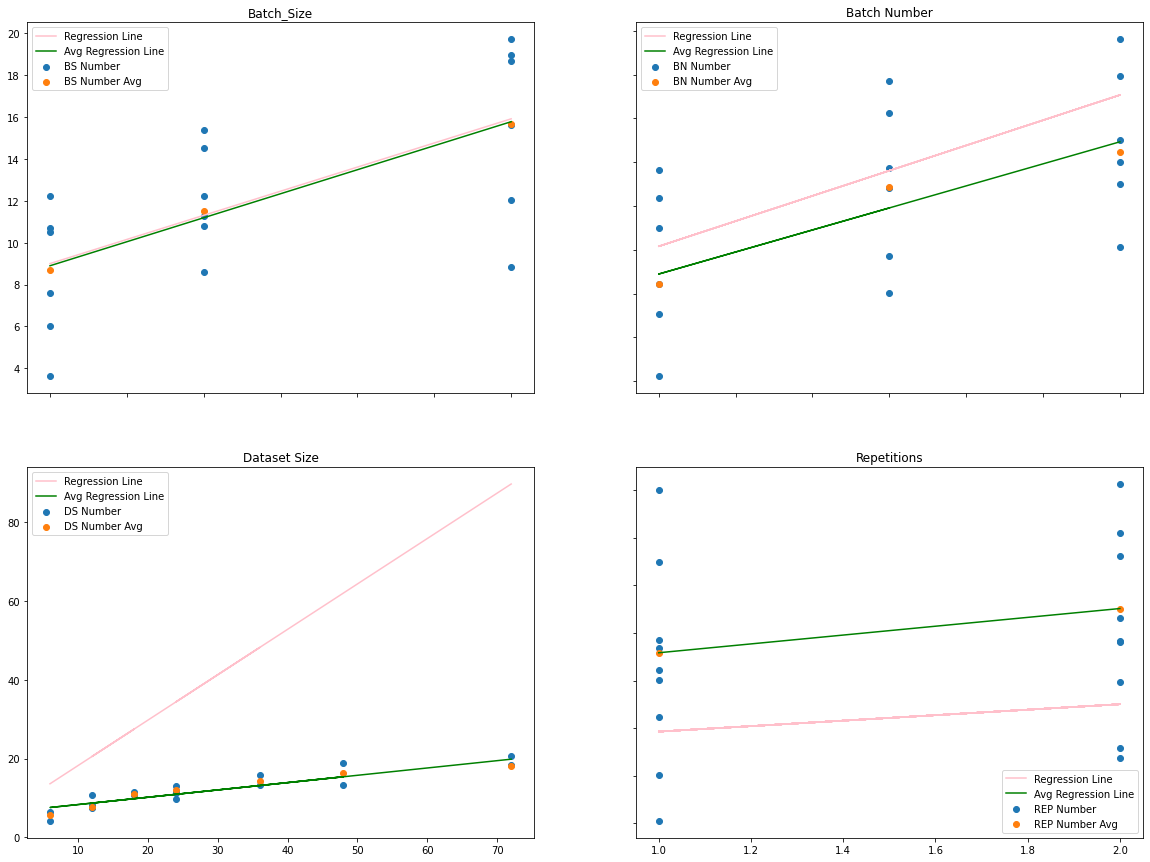

In [ ]:
import matplotlib.pyplot as plt
import numpy
import random

result1 =img_bs_df_lr.predict(img_bs_df[[0]])
result_avg1 = img_bs_df_avg_lr.predict(img_bs_df_avg[[0]])

result2 =img_bn_df_lr.predict(img_bn_df[[0]])
result_avg2 = img_bn_df_avg_lr.predict(img_bn_df_avg[[0]])

result3 =img_ds_df_lr.predict(img_ds_df[[0]])
result_avg3 = img_ds_df_avg_lr.predict(img_ds_df_avg[[0]])

result4 =img_rep_df_lr.predict(img_rep_df[[0]])
result_avg4 = img_rep_df_avg_lr.predict(img_rep_df_avg[[0]])


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20,15))


ax1.scatter(img_bs_df[[0]], img_bs_df[[1]], label = 'BS Number')
ax1.scatter(img_bs_df_avg[[0]], img_bs_df_avg[[1]], label = 'BS Number Avg')
ax1.plot(img_bs_df[[0]], result1, color='pink', label = 'Regression Line')
ax1.plot(img_bs_df_avg[[0]], result_avg1, color='green', label = 'Avg Regression Line')
ax1.set_title('Batch_Size')
ax1.legend()


ax2.scatter(img_bn_df[[0]], img_bn_df[[1]], label = 'BN Number')
ax2.scatter(img_bn_df_avg[[0]], img_bn_df_avg[[1]], label = 'BN Number Avg')
ax2.plot(img_bn_df[[0]], result2, color='pink', label = 'Regression Line')
ax2.plot(img_bn_df_avg[[0]], result_avg2, color='green', label = 'Avg Regression Line')
ax2.set_title('Batch Number')
ax2.legend()


ax3.scatter(img_ds_df[[0]], img_ds_df[[1]], label = 'DS Number')
ax3.scatter(img_ds_df_avg[[0]], img_ds_df_avg[[1]], label = 'DS Number Avg')
ax3.plot(img_ds_df[[0]], result3, color='pink', label = 'Regression Line')
ax3.plot(img_ds_df_avg[[0]], result_avg3, color='green', label = 'Avg Regression Line')
ax3.set_title('Dataset Size')
ax3.legend()


ax4.scatter(img_rep_df[[0]], img_rep_df[[1]], label = 'REP Number')
ax4.scatter(img_rep_df_avg[[0]], img_rep_df_avg[[1]], label = 'REP Number Avg')
ax4.plot(img_rep_df[[0]], result4, color='pink', label = 'Regression Line')
ax4.plot(img_rep_df_avg[[0]], result_avg4, color='green', label = 'Avg Regression Line')
ax4.set_title('Repetitions')
ax4.legend()


for ax in fig.get_axes():
    ax.label_outer()

In [ ]:

print('Slope')
print(img_bs_df_lr.coef_)
print(img_bn_df_lr.coef_)
print(img_ds_df_lr.coef_)
print(img_rep_df_lr.coef_)

print('Intercept')
print(img_bs_df_lr.intercept_)
print(img_bn_df_lr.intercept_)
print(img_ds_df_lr.intercept_)
print(img_rep_df_lr.intercept_)

print('Score')
print(img_bs_df_lr.score(img_ds_df[[0]], img_ds_df[[1]]))
print(img_bn_df_lr.score(img_bn_df[[0]], img_bn_df[[1]]))
print(img_ds_df_lr.score(img_ds_df[[0]], img_ds_df[[1]]))
print(img_rep_df_lr.score(img_rep_df[[0]], img_rep_df[[1]]))


Slope
[[1.15204289]]
[[1.15204289]]
[[1.15204289]]
[[1.15204289]]
Intercept
[6.69991499]
[6.69991499]
[6.69991499]
[6.69991499]
Score
-58.728765599060885
0.21802291211692748
-58.728765599060885
-0.5184550109662749


In [ ]:
# Appling Linear Regression on our secondary dataset
tf_bs_df_lr = LinearRegression()
tf_bn_df_lr = LinearRegression()
tf_ds_df_lr = LinearRegression()
tf_rep_df_lr = LinearRegression()

tf_bs_df_avg_lr = LinearRegression()
tf_bn_df_avg_lr = LinearRegression()
tf_ds_df_avg_lr = LinearRegression()
tf_rep_df_avg_lr = LinearRegression()

In [ ]:
tf_bs_df_lr.fit(tf_bs_df[[0]],tf_bs_df[[1]])
tf_bn_df_lr.fit(tf_bn_df[[0]],tf_bn_df[[1]])
tf_ds_df_lr.fit(tf_ds_df[[0]],tf_ds_df[[1]])
tf_rep_df_lr.fit(tf_rep_df[[0]],tf_rep_df[[1]])

tf_bs_df_avg_lr.fit(tf_bs_df_avg[[0]],tf_bs_df_avg[[1]])
tf_bn_df_avg_lr.fit(tf_bn_df_avg[[0]],tf_bn_df_avg[[1]])
tf_ds_df_avg_lr.fit(tf_ds_df_avg[[0]],tf_ds_df_avg[[1]])
tf_rep_df_avg_lr.fit(tf_rep_df_avg[[0]],tf_rep_df_avg[[1]])


LinearRegression()

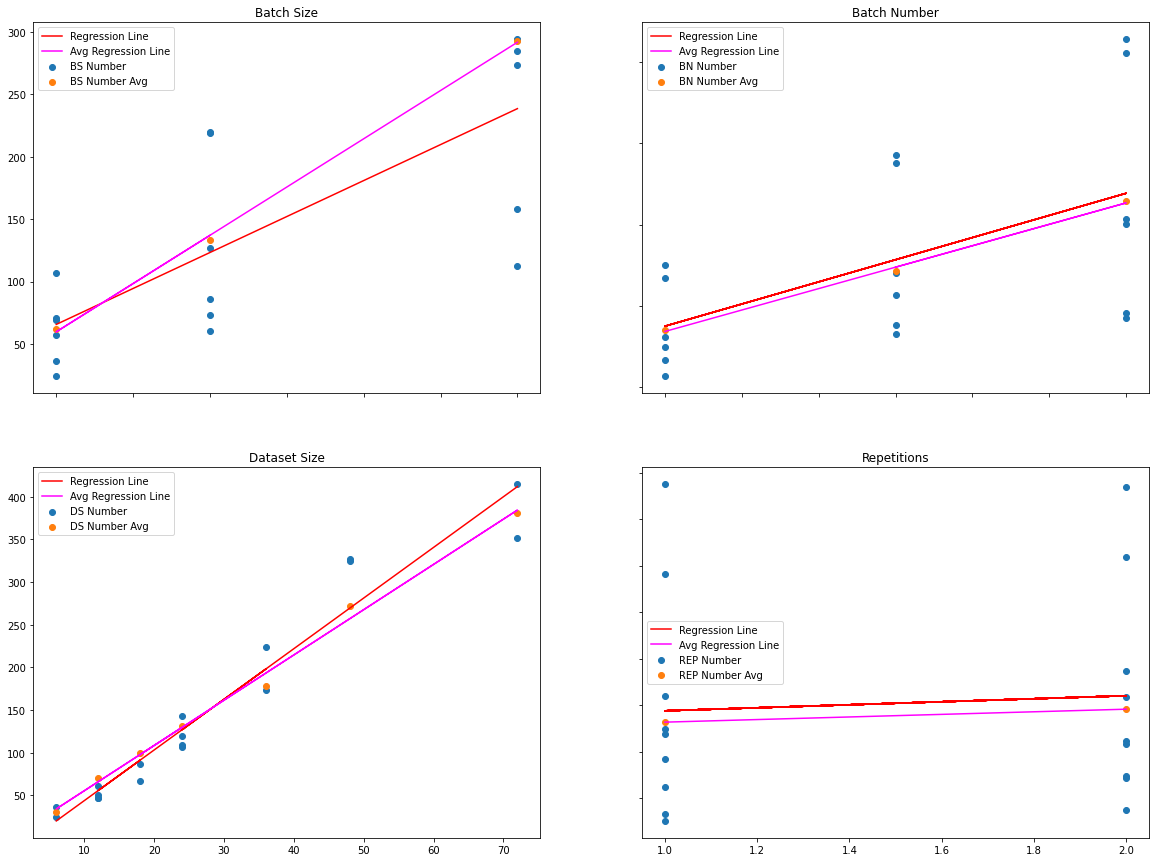

In [ ]:
result5 =tf_bs_df_lr.predict(tf_bs_df[[0]])
result_avg5 =tf_bs_df_avg_lr.predict(tf_bs_df_avg[[0]])

result6 =tf_bn_df_lr.predict(tf_bn_df[[0]])
result_avg6 =tf_bn_df_avg_lr.predict(tf_bn_df_avg[[0]])

result7 =tf_ds_df_lr.predict(tf_ds_df[[0]])
result_avg7 =tf_ds_df_avg_lr.predict(tf_ds_df_avg[[0]])

result8 =tf_rep_df_lr.predict(tf_rep_df[[0]])
result_avg8 =tf_rep_df_avg_lr.predict(tf_rep_df_avg[[0]])

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20,15))

ax1.scatter(tf_bs_df[[0]], tf_bs_df[[1]], label = 'BS Number')
ax1.scatter(tf_bs_df_avg[[0]], tf_bs_df_avg[[1]], label = 'BS Number Avg')
ax1.plot(tf_bs_df[[0]], result5, color='red', label = 'Regression Line')
ax1.plot(tf_bs_df_avg[[0]], result_avg5, color='magenta', label = 'Avg Regression Line')
ax1.set_title('Batch Size')
ax1.legend()


ax2.scatter(tf_bn_df[[0]], tf_bn_df[[1]], label = 'BN Number')
ax2.scatter(tf_bn_df_avg[[0]], tf_bn_df_avg[[1]], label = 'BN Number Avg')
ax2.plot(tf_bn_df[[0]], result6, color='red', label = 'Regression Line')
ax2.plot(tf_bn_df_avg[[0]], result_avg6, color='magenta', label = 'Avg Regression Line')
ax2.set_title('Batch Number')
ax2.legend()


ax3.scatter(tf_ds_df[[0]], tf_ds_df[[1]], label = 'DS Number')
ax3.scatter(tf_ds_df_avg[[0]], tf_ds_df_avg[[1]], label = 'DS Number Avg')
ax3.plot(tf_ds_df[[0]], result7, color='red', label = 'Regression Line')
ax3.plot(tf_ds_df_avg[[0]], result_avg7, color='magenta', label = 'Avg Regression Line')
ax3.set_title('Dataset Size')
ax3.legend()


ax4.scatter(tf_rep_df[[0]], tf_rep_df[[1]], label = 'REP Number')
ax4.scatter(tf_rep_df_avg[[0]], tf_rep_df_avg[[1]], label = 'REP Number Avg')
ax4.plot(tf_rep_df[[0]], result8, color='red', label = 'Regression Line')
ax4.plot(tf_rep_df_avg[[0]], result_avg8, color='magenta', label = 'Avg Regression Line')
ax4.set_title('Repetitions')
ax4.legend()

for ax in fig.get_axes():
    ax.label_outer()

In [ ]:
print('Slope')
print(tf_bs_df_lr.coef_)
print(tf_bn_df_lr.coef_)
print(tf_ds_df_lr.coef_)
print(tf_rep_df_lr.coef_)

print('Intercept')
print(tf_bs_df_lr.intercept_)
print(tf_bn_df_lr.intercept_)
print(tf_ds_df_lr.intercept_)
print(tf_rep_df_lr.intercept_)

print('Score')
print(tf_bs_df_lr.score(tf_ds_df[[0]], tf_ds_df[[1]]))
print(tf_bn_df_lr.score(tf_bn_df[[0]], tf_bn_df[[1]]))
print(tf_ds_df_lr.score(tf_ds_df[[0]], tf_ds_df[[1]]))
print(tf_rep_df_lr.score(tf_rep_df[[0]], tf_rep_df[[1]]))

Slope
[[28.83301458]]
[[27.18718954]]
[[5.93597959]]
[[16.17907549]]
Intercept
[7.98815582]
[-6.25531742]
[-15.47358631]
[127.99188131]
Score
-43.49976824083837
0.3120276462484054
0.9486406937686486
0.005175167423229543


In [ ]:
# From the above Linear Regression analysis,we can see each of the variable varying with the time taken for reading.

# Section 3: Machine Learning in the Cloud

In this section we will use the pre-processed data with the Google Cloud AI-Platform for Machine Learning. 

## Preparation: Machine Learning Setup

As in Section 1, in this section, we get started based on code from the 'Fast and Lean Data Science' course, this time lecture 4, to establish the task.

Switch to a runtime with a GPU before you run this section. You'll need to re-run section 0 and 1 up to (but not including) Task 1 after you switch runtimes to set everything up. 


### Create Train and Test Sets 

We will first **set up a few variables** for the machine learning. 

In [ ]:
BATCH_SIZE = 64 # this is a good setting for the standard Colab GPU (K80)
#BATCH_SIZE = 128 # works on newer GPUs with more memory (available on GCS AI-Platform) 
EPOCHS = 5 # 5 is for testing. Increase later
GCS_TFR_PATTERN = 'gs://flowers-public/tfrecords-jpeg-192x192-2/*.tfrec' 
# this is a link to public data, you can use your own if you like
VALIDATION_SPLIT = 0.19 # proportion of data used for validation
SAMPLE_NUM = 3670 # size of the Flowers dataset, change as appropriate for smaller samples/different datasets

Then we split the data into train and test sets.

In [ ]:
# splitting data files between training and validation
filenames = tf.io.gfile.glob(GCS_TFR_PATTERN)
print("len(filenames): "+str(len(filenames)))
split = int(len(filenames) * VALIDATION_SPLIT)
training_filenames = filenames[split:]
validation_filenames = filenames[:split]
print("Pattern matches {} data files. Splitting dataset into {} training files and {} validation files".format(len(filenames), len(training_filenames), len(validation_filenames)))
validation_steps = int(SAMPLE_NUM // len(filenames) * len(validation_filenames)) // BATCH_SIZE
steps_per_epoch = int(SAMPLE_NUM // len(filenames) * len(training_filenames)) // BATCH_SIZE
print("With a batch size of {}, there will be {} batches per training epoch and {} batch(es) per validation run.".format(BATCH_SIZE, steps_per_epoch, validation_steps))

len(filenames): 16
Pattern matches 16 data files. Splitting dataset into 13 training files and 3 validation files
With a batch size of 64, there will be 46 batches per training epoch and 10 batch(es) per validation run.


Then we split the train and validation sets into batches. 

In [ ]:
def get_batched_dataset(filenames, train=False):
    dataset = load_dataset(filenames)
    dataset = dataset.cache() # This dataset fits in RAM
    if train:
        # Best practices for Keras:
        # Training dataset: repeat then batch
        # Evaluation dataset: do not repeat
        dataset = dataset.repeat()
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(1) # prefetch next batch while training 
    # should shuffle too but this dataset was well shuffled on disk already
    return dataset
    # source: Dataset performance guide: https://www.tensorflow.org/guide/performance/datasets

# instantiate the datasets
training_dataset = get_batched_dataset(training_filenames, train=True)
validation_dataset = get_batched_dataset(validation_filenames, train=False)

In [ ]:
# just a little test to check the datasets
sample_set = training_dataset.take(4)
for image, label in sample_set: 
    print("Image batch shape {}, {})".format(image.numpy().shape,
                        [str(lbl) for lbl in label.numpy()]))

Image batch shape (64, 192, 192, 3), ['0', '0', '4', '1', '0', '2', '0', '1', '3', '4', '2', '1', '3', '1', '0', '2', '4', '3', '4', '1', '4', '0', '0', '4', '4', '1', '4', '4', '0', '3', '2', '3', '3', '3', '3', '1', '0', '1', '3', '4', '3', '1', '1', '4', '2', '4', '1', '3', '2', '3', '3', '0', '3', '3', '3', '2', '0', '4', '4', '1', '4', '1', '3', '1'])
Image batch shape (64, 192, 192, 3), ['4', '4', '2', '0', '2', '2', '4', '1', '3', '3', '3', '1', '4', '2', '3', '4', '1', '3', '2', '1', '0', '2', '3', '0', '2', '4', '1', '2', '4', '3', '2', '3', '3', '4', '3', '3', '1', '2', '1', '4', '4', '4', '0', '2', '3', '4', '2', '1', '1', '4', '0', '3', '0', '4', '4', '4', '1', '1', '4', '4', '1', '3', '3', '0'])
Image batch shape (64, 192, 192, 3), ['3', '0', '1', '3', '1', '4', '2', '0', '0', '0', '2', '4', '4', '4', '2', '3', '2', '3', '0', '4', '2', '4', '1', '2', '1', '0', '4', '0', '1', '1', '4', '0', '4', '2', '3', '4', '3', '3', '1', '4', '2', '3', '1', '1', '4', '2', '2', '1', '1',

### Set up a pretrained model

Here we load a **pre-trained model** and add a **fully connected** layer plus the **output layer**.
**Only** our **added layers** are **trained**, which lets us benefit from the trained model without the computation or data needed to re-train from scratch.

We use **MobileNetV2** here, which is a **relatively small and efficient** model. You can also try the larger ones, if you like. 

In [ ]:
pretrained_model = tf.keras.applications.MobileNetV2(input_shape=[*TARGET_SIZE, 3], include_top=False)
pretrained_model.trainable = False

model = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100,activation='relu'),
    tf.keras.layers.Dropout(.5),
    tf.keras.layers.Dense(5, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

9420800/9406464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_192 (Funct  (None, 6, 6, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten (Flatten)           (None, 46080)             0         
                                                                 
 dense (Dense)               (None, 100)               4608100   
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 505       
                                                                 
Total params: 6,866,589
Trainable params: 4,608,605
Non-tra

### Local Training

With **model and data**, we can now start the **training**. You can keep training time short by making sure that you use a runtime with GPU. You should also the number of epochs low, for initial tests. 
The **history** object keeps a record of the training progress.

In [ ]:
tt0 = time.time()
history = model.fit(training_dataset, steps_per_epoch=steps_per_epoch, epochs=5,
                    validation_data=validation_dataset, validation_steps=validation_steps)
tt = time.time() - tt0
print("Wall clock time = {}".format(tt))

Epoch 1/5
46/46 [==============================] - 80s 2s/step - loss: 3.1769 - accuracy: 0.2534 - val_loss: 1.6118 - val_accuracy: 0.2500
Epoch 2/5
46/46 [==============================] - 67s 1s/step - loss: 1.5991 - accuracy: 0.2653 - val_loss: 1.6072 - val_accuracy: 0.2406
Epoch 3/5
46/46 [==============================] - 73s 2s/step - loss: 1.6095 - accuracy: 0.2500 - val_loss: 1.6057 - val_accuracy: 0.2422
Epoch 4/5
46/46 [==============================] - 74s 2s/step - loss: 1.5828 - accuracy: 0.2683 - val_loss: 1.5868 - val_accuracy: 0.2937
Wall clock time = 388.0554721355438


As a result we have the printed training time, the trained model, and the history object, which we can visualise (not essential for us here).

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


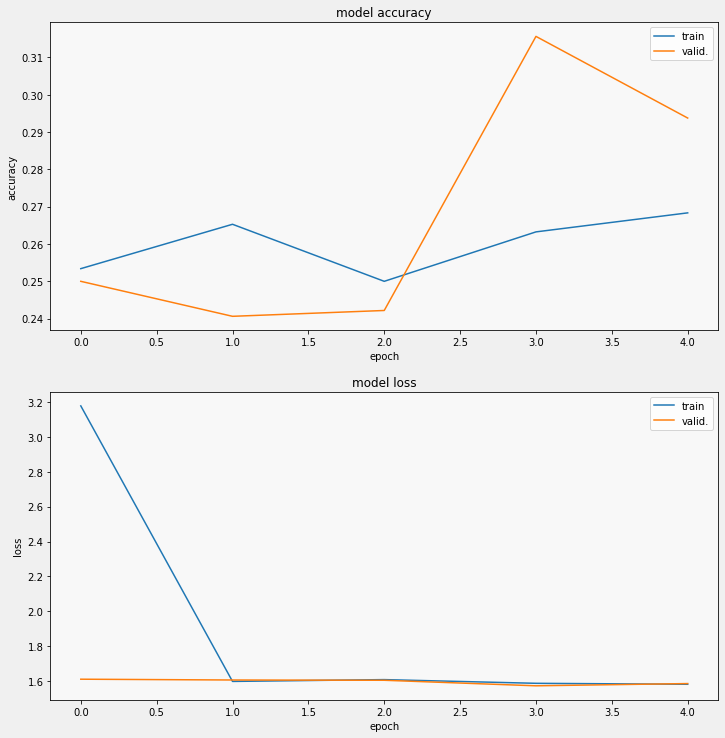

In [ ]:
print(history.history.keys())
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

We can check a few examples with the predicted classes.

In [ ]:
# random input: execute multiple times to change results
flowers, labels = dataset_to_numpy_util(load_dataset(validation_filenames).skip(np.random.randint(300)), 9)

predictions = model.predict(flowers, steps=1)
print(np.array(CLASSES)[np.argmax(predictions, axis=-1)].tolist())

[b'dandelion', b'dandelion', b'tulips', b'tulips', b'tulips', b'dandelion', b'dandelion', b'dandelion', b'dandelion']


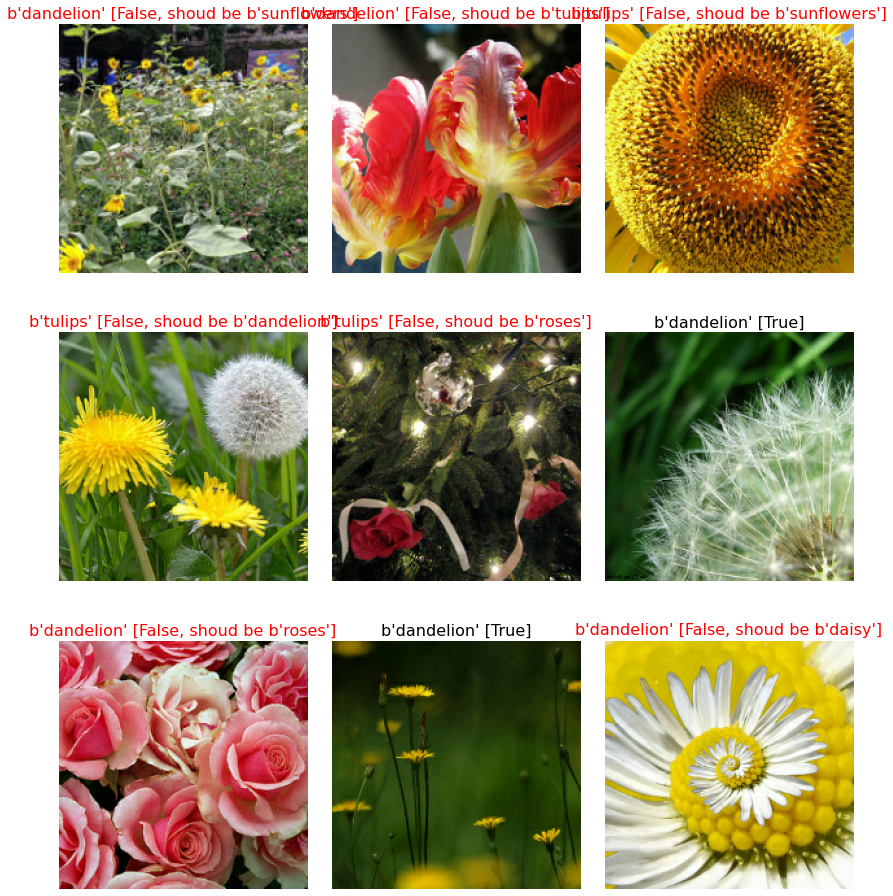

In [ ]:
display_9_images_with_predictions(flowers, predictions, labels)

## Task 3: Machine learning in the cloud (20%)

Your task is now to **execute** the **training** in the **cloud** on the **AI-Platform** and experiment with different parallelisation approaches.


### 3a) Create the package and code for the AI-Platform (7%)

The AI Platform needs code in a '**package**'. 
The package can contain complex software systems and extensive  information on the setup. 
We will **keep** the package as **simple** as possible here.



i) The **minimal** 'package' in for AI-Platform needs a directory with **two modules** (i.e. Python files). 
Create a directory 'trainer' and then an empty file **`trainer/__init__.py`**. 
This can be done by using the **command line tool `touch`**. 
**Check** that the file **exists**. (1%) 

In [ ]:
### CODING TASK ###

# From the given data inputs, we can observe that the accuracy and loss values are very low. But the data provided and the methodology used cannot find any errors. Hence proceding with the analysis even though the metrices are incorrect.

!mkdir trainer
!touch trainer/__init__.py
!ls -R # Display the contents and give read aceess

.:
spark-2.4.8-bin-hadoop2.7  Task2a.pkl  task2.py  trainer

./spark-2.4.8-bin-hadoop2.7:
bin   data	jars	    LICENSE   NOTICE  R		 RELEASE  yarn
conf  examples	kubernetes  licenses  python  README.md  sbin

./spark-2.4.8-bin-hadoop2.7/bin:
beeline		      pyspark		spark-class.cmd   spark-sql
beeline.cmd	      pyspark2.cmd	sparkR		  spark-sql2.cmd
docker-image-tool.sh  pyspark.cmd	sparkR2.cmd	  spark-sql.cmd
find-spark-home       run-example	sparkR.cmd	  spark-submit
find-spark-home.cmd   run-example.cmd	spark-shell	  spark-submit2.cmd
load-spark-env.cmd    spark-class	spark-shell2.cmd  spark-submit.cmd
load-spark-env.sh     spark-class2.cmd	spark-shell.cmd

./spark-2.4.8-bin-hadoop2.7/conf:
docker.properties.template  metrics.properties.template   spark-env.sh.template
fairscheduler.xml.template  slaves.template
log4j.properties.template   spark-defaults.conf.template

./spark-2.4.8-bin-hadoop2.7/data:
graphx	mllib  streaming

./spark-2.4.8-bin-hadoop2.7/data/graphx:
followers.txt  use

ii) The other file we need is the **module** with the **training code**, which we will call **`task.py`**. 

We can build this file by **combining** the **previous cells** under 'Machine Learning Setup' into one file, almost literally. 

Then, we need to **save the model itself** and the **training history** into a file after training. 
You can not pickle the `history` object returned by `model.fit`, but its **data in `history.history`** can be **pickled**. 
For **saving the model**, use `model.save()`.
In addition, **save** the measured **training time** and information about the **configuration** (should be passed as a parameter). 
Write the necessary code, like in section 2 when preparing jobs for Spark/Dataproc.

If you use **argparse** as in section 2 (recommended), then you need to **define an argument** `--job-dir` that will be passed through from the AI-Platform to your program when you define it.
(6%)

In [ ]:
### CODING TASK ###

%%writefile trainer/task.py
# $ pip install pyspark
# import pyspark
# from pyspark.sql import SQLContext
# from pyspark.sql import Row
import os, sys, math
import numpy as np
import time
import datetime
import string
import random
from matplotlib import pyplot as plt
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
import pickle
import argparse



PROJECT = 'airy-lodge-348916'

BUCKET = 'gs://{}-storage'.format(PROJECT)
GCS_PATTERN = 'gs://flowers-public/*/*.jpg' # glob  pattern for input files
PARTITIONS = 16 # no of partitions we will use later 
TARGET_SIZE = [192, 192] # target resolution for the images
CLASSES = [b'daisy', b'dandelion', b'roses', b'sunflowers', b'tulips']



GCS_OUTPUT = 'gs://flowers-public/tfrecords-jpeg-192x192-2/' 
# remove the line above to use your own files that you generated above

def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        "class": tf.io.FixedLenFeature([], tf.int64) #,   # shape [] means scalar
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [*TARGET_SIZE, 3])    
    class_num = example['class']
    return image, class_num 

def load_dataset(filenames):
    # read from TFRecords. For optimal performance, read from multiple    
    # TFRecord files at once and set the option experimental_deterministic = False
    # to allow order-altering optimizations.
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False

    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.map(read_tfrecord)
    return dataset

def display_training_curves(training, validation, title, subplot):
  if subplot%10==1: # set up the subplots on the first call
    plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
    plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.set_facecolor('#F8F8F8')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])

    
filenames = tf.io.gfile.glob(GCS_OUTPUT + "*.tfrec")
datasetTfrec = load_dataset(filenames)   #( FROM NOW WE WILL CALL datasetTfrec as SECONDARY DATASET WHICH WILL BE USED IN SECTION 2 OF THIS NOTEBOOK AND FURTHER)




BATCH_SIZE = 64 # this is a good setting for the standard Colab GPU (K80)
#BATCH_SIZE = 128 # works on newer GPUs with more memory (available on GCS AI-Platform) 
EPOCHS = 5 # 5 is for testing. Increase later
GCS_TFR_PATTERN = 'gs://flowers-public/tfrecords-jpeg-192x192-2/*.tfrec' 
# this is a link to public data, you can use your own if you like
VALIDATION_SPLIT = 0.19 # proportion of data used for validation
SAMPLE_NUM = 3670 # size of the Flowers dataset, change as appropriate for smaller samples/different datasets

# From the lab Lab 4a part3: Connecting to the Google Cloud from Colab we are using the save function. 

# https://colab.research.google.com/drive/1jZdnYNez89vAEJzeWrjcKS2gd7-R_U3C

def save(object,bucket,filename):
    with open(filename,mode='wb') as f:
        pickle.dump(object,f)
    print("Saving {} to {}".format(filename,bucket))
    import subprocess
    proc = subprocess.run(["gsutil","cp", filename, bucket],stderr=subprocess.PIPE)
    print("gstuil returned: " + str(proc.returncode))
    print(str(proc.stderr))


def runWordCount(argv): 
    # Parse the provided arguments
    print(argv)
    parser = argparse.ArgumentParser() # get a parser object
    parser.add_argument('--out_bucket', metavar='out_bucket', required=True,
                        help='The bucket URL for the result.') # add a required argument
    parser.add_argument('--out_file', metavar='out_file', required=True,
                        help='The filename for the result.') # add a required argument
    args = parser.parse_args(argv) # read the value
    # the value provided with --out_bucket is now in args.out_bucket
    # sc = pyspark.SparkContext.getOrCreate()
    # rdd = sc.parallelize(['Hello,', 'world!'])
    # words = sorted(rdd.collect())




    # splitting data files between training and validation
    filenames = tf.io.gfile.glob(GCS_TFR_PATTERN)
    print("len(filenames): "+str(len(filenames)))
    split = int(len(filenames) * VALIDATION_SPLIT)
    training_filenames = filenames[split:]
    validation_filenames = filenames[:split]
    print("Pattern matches {} data files. Splitting dataset into {} training files and {} validation files".format(len(filenames), len(training_filenames), len(validation_filenames)))
    validation_steps = int(SAMPLE_NUM // len(filenames) * len(validation_filenames)) // BATCH_SIZE
    steps_per_epoch = int(SAMPLE_NUM // len(filenames) * len(training_filenames)) // BATCH_SIZE
    print("With a batch size of {}, there will be {} batches per training epoch and {} batch(es) per validation run.".format(BATCH_SIZE, steps_per_epoch, validation_steps))

    # instantiate the datasets
    training_dataset = get_batched_dataset(training_filenames, train=True)
    validation_dataset = get_batched_dataset(validation_filenames, train=False)


    # just a little test to check the datasets
    sample_set = training_dataset.take(4)
    for image, label in sample_set: 
        print("Image batch shape {}, {})".format(image.numpy().shape,
                            [str(lbl) for lbl in label.numpy()]))
        

    pretrained_model = tf.keras.applications.MobileNetV2(input_shape=[*TARGET_SIZE, 3], include_top=False)
    pretrained_model.trainable = False

    model = tf.keras.Sequential([
        pretrained_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(100,activation='relu'),
        tf.keras.layers.Dropout(.5),
        tf.keras.layers.Dense(5, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss = 'sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # model.summary()

    tt0 = time.time()
    history = model.fit(training_dataset, steps_per_epoch=steps_per_epoch, epochs=5,
                        validation_data=validation_dataset, validation_steps=validation_steps)
    tt = time.time() - tt0

    save(history.history,args.out_bucket,args.out_file)
    print("Wall clock time = {}".format(tt))
    save(tt,args.out_bucket,args.out_file)

    print(history.history.keys())
    display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
    display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)


def get_batched_dataset(filenames, train=False):
    dataset = load_dataset(filenames)
    dataset = dataset.cache() # This dataset fits in RAM
    if train:
        # Best practices for Keras:
        # Training dataset: repeat then batch
        # Evaluation dataset: do not repeat
        dataset = dataset.repeat()
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(1) # prefetch next batch while training 
    # should shuffle too but this dataset was well shuffled on disk already
    return dataset
    # source: Dataset performance guide: https://www.tensorflow.org/guide/performance/datasets



# if  'google.colab' not in sys.modules: # Don't use system arguments running in Colab 
    # runWordCount(sys.argv[1:])  
if __name__ == "__main__" : # but define them manually
    filename = 'Task_3b.pkl'
    PROJECT = 'airy-lodge-348916'
    BUCKET = 'gs://{}-storage'.format(PROJECT)
    runWordCount(["--out_bucket", BUCKET, "--out_file",filename])


Overwriting trainer/task.py


In [ ]:
 %run task.py

### 3b) Run the Training on the AI-Platform and view the Output (3%)

Now, with all code in place, we can **submit the package as a job**. AI-Platform operation is **serverless**, therefore we do not need to create a cluster ourselves, but we just submit a job and the master and workers will be provided automatically. 
Find [here](https://cloud.google.com/sdk/gcloud/reference/ai-platform/jobs/submit/training) the information **how to submit a training job** in GCS AI-Platform.  

The **job** will wait in a **queue** for **some minutes** before it gets executed, this can take several minutes (at least on free credits). 
It's therefore a good idea to **test** the script **locally before** you submit to the **cloud**. 

You can get **powerful hardware** on AI-Platform. Up to 30 K80 or even P100 GPUs are available, but not all configurations are possible. 
Check [here](https://cloud.google.com/ai-platform/training/docs/quotas#gpu-quota) and [here](https://cloud.google.com/ai-platform/training/docs/using-gpus), and test [here on the console](https://console.cloud.google.com/ai-platform/create-job/custom-code?folder=true&organizationId=true) with the Create option whether your configuration works in the Google Cloud.

However, the machines with P100 and V100 GPUs are quite **expensive**. 
For the experiments here, the `standard_gpu` (1xK80) and the `complex_model_l_gpu` (8xK80) are sufficient.


In [ ]:
TRAINER_PACKAGE_PATH="trainer"
MAIN_TRAINER_MODULE="trainer.task"
import datetime
NOW=datetime.datetime.now().strftime("%y%m%d_%H%M")
JOB_NAME = "Task3b"+NOW
PROJECT = 'airy-lodge-348916'
BUCKET = 'gs://{}-storage'.format(PROJECT)
PACKAGE_STAGING_PATH=BUCKET
JOB_DIR=BUCKET+'/jobs/'+JOB_NAME

!gcloud ai-platform jobs submit training $JOB_NAME \
    --package-path $TRAINER_PACKAGE_PATH \
    --module-name $MAIN_TRAINER_MODULE \
    --runtime-version 2.3 \
    --python-version 3.7 \
    --job-dir $JOB_DIR  \
    --scale-tier custom    \
    --master-machine-type n1-standard-8 \
    --master-accelerator count=1,type=nvidia-tesla-p4

Job [Task3b220504_1256] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ai-platform jobs describe Task3b220504_1256

or continue streaming the logs with the command

  $ gcloud ai-platform jobs stream-logs Task3b220504_1256
jobId: Task3b220504_1256
state: QUEUED


Normally, gcloud returns immediately after job submission. If you want to keep track here, you can use the cell below. Usually, it is more practical to use the web interface https://console.cloud.google.com/ai-platform/jobs .

In [ ]:
!gcloud ai-platform jobs stream-logs $JOB_NAME

INFO	2022-05-04 12:56:59 +0000	service		Validating job requirements...
INFO	2022-05-04 12:56:59 +0000	service		Job creation request has been successfully validated.
INFO	2022-05-04 12:56:59 +0000	service		Waiting for job to be provisioned.
INFO	2022-05-04 12:56:59 +0000	service		Job Task3b220504_1256 is queued.
INFO	2022-05-04 12:57:01 +0000	service		Waiting for training program to start.
NOTICE	2022-05-04 12:58:01 +0000	master-replica-0.gcsfuse		Opening GCS connection...
NOTICE	2022-05-04 12:58:01 +0000	master-replica-0.gcsfuse		Mounting file system "gcsfuse"...
NOTICE	2022-05-04 12:58:01 +0000	master-replica-0.gcsfuse		File system has been successfully mounted.
INFO	2022-05-04 13:01:21 +0000	master-replica-0		Running task with arguments: --cluster={"chief": ["127.0.0.1:2222"]} --task={"type": "chief", "index": 0} --job={  "scale_tier": "CUSTOM",  "master_type": "n1-standard-8",  "package_uris": ["gs://airy-lodge-348916-storage/jobs/Task3b220504_1256/packages/80610f7055c315e5bb59836ea

After training, **retrieve the history object and plot** the accuracy and loss curves based on the saved history to **check that the training worked**.

In [ ]:
### CODING TASK ### 


### 3c) Distributed learning	(10%)

Apply **distributed learning strategies** to the code (see https://www.tensorflow.org/tutorials/distribute/multi_worker_with_keras?hl=nb#choose_the_right_strategy for an example).  
Add the necessary changes to the code.

**Experiment** with **different strategies and batch sizes**. Report and interpret your results. 
For the defining cluster sizes, you can use command line options as described here: https://cloud.google.com/ai-platform/training/docs/machine-types#legacy-machine-types . 
Check the pricing here ( https://cloud.google.com/ai-platform/training/pricing ) and make sure everything works before you run jobs on the expensive configurations. 


In [ ]:
### CODING TASK ###

!mkdir DLtrainer
!touch DLtrainer/__init__.py
!ls -R # Display the contents and give read aceess

.:
DLtrainer  spark-2.4.8-bin-hadoop2.7  Task2a.pkl  task2.py  trainer

./DLtrainer:
__init__.py

./spark-2.4.8-bin-hadoop2.7:
bin   data	jars	    LICENSE   NOTICE  R		 RELEASE  yarn
conf  examples	kubernetes  licenses  python  README.md  sbin

./spark-2.4.8-bin-hadoop2.7/bin:
beeline		      pyspark		spark-class.cmd   spark-sql
beeline.cmd	      pyspark2.cmd	sparkR		  spark-sql2.cmd
docker-image-tool.sh  pyspark.cmd	sparkR2.cmd	  spark-sql.cmd
find-spark-home       run-example	sparkR.cmd	  spark-submit
find-spark-home.cmd   run-example.cmd	spark-shell	  spark-submit2.cmd
load-spark-env.cmd    spark-class	spark-shell2.cmd  spark-submit.cmd
load-spark-env.sh     spark-class2.cmd	spark-shell.cmd

./spark-2.4.8-bin-hadoop2.7/conf:
docker.properties.template  metrics.properties.template   spark-env.sh.template
fairscheduler.xml.template  slaves.template
log4j.properties.template   spark-defaults.conf.template

./spark-2.4.8-bin-hadoop2.7/data:
graphx	mllib  streaming

./spark-2.4.8-bin-hado

In [ ]:
### CODING TASK ###

%%writefile DLtrainer/OneDevice.py
# $ pip install pyspark
# import pyspark
# from pyspark.sql import SQLContext
# from pyspark.sql import Row
import os, sys, math
import numpy as np
import time
import datetime
import string
import random
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
import pickle
import argparse




TF_CONFIG = os.environ.get('TF_CONFIG')
if TF_CONFIG and '"master"' in TF_CONFIG:
  os.environ['TF_CONFIG'] = TF_CONFIG.replace('"master"', '"chief"')

strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")

PROJECT = 'airy-lodge-348916'
BUCKET = 'gs://{}-storage'.format(PROJECT)
GCS_PATTERN = 'gs://flowers-public/*/*.jpg' # glob  pattern for input files
PARTITIONS = 16 # no of partitions we will use later 
TARGET_SIZE = [192, 192] # target resolution for the images
CLASSES = [b'daisy', b'dandelion', b'roses', b'sunflowers', b'tulips']



GCS_OUTPUT = 'gs://flowers-public/tfrecords-jpeg-192x192-2/' 
# remove the line above to use your own files that you generated above

def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        "class": tf.io.FixedLenFeature([], tf.int64) #,   # shape [] means scalar
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [*TARGET_SIZE, 3])    
    class_num = example['class']
    return image, class_num 

def load_dataset(filenames):
    # read from TFRecords. For optimal performance, read from multiple    
    # TFRecord files at once and set the option experimental_deterministic = False
    # to allow order-altering optimizations.
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False

    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.map(read_tfrecord)
    return dataset

    
filenames = tf.io.gfile.glob(GCS_OUTPUT + "*.tfrec")
datasetTfrec = load_dataset(filenames)   #( FROM NOW WE WILL CALL datasetTfrec as SECONDARY DATASET WHICH WILL BE USED IN SECTION 2 OF THIS NOTEBOOK AND FURTHER)




# BATCH_SIZE = 64 # this is a good setting for the standard Colab GPU (K80)

BATCH_SIZE = 128
#BATCH_SIZE = 128 # works on newer GPUs with more memory (available on GCS AI-Platform) 
EPOCHS = 5 # 5 is for testing. Increase later
GCS_TFR_PATTERN = 'gs://flowers-public/tfrecords-jpeg-192x192-2/*.tfrec' 
# this is a link to public data, you can use your own if you like
VALIDATION_SPLIT = 0.19 # proportion of data used for validation
SAMPLE_NUM = 3670 # size of the Flowers dataset, change as appropriate for smaller samples/different datasets

# From the lab Lab 4a part3: Connecting to the Google Cloud from Colab we are using the save function. 

# https://colab.research.google.com/drive/1jZdnYNez89vAEJzeWrjcKS2gd7-R_U3C

def save(object,bucket,filename):
    with open(filename,mode='wb') as f:
        pickle.dump(object,f)
    print("Saving {} to {}".format(filename,bucket))
    import subprocess
    proc = subprocess.run(["gsutil","cp", filename, bucket],stderr=subprocess.PIPE)
    print("gstuil returned: " + str(proc.returncode))
    print(str(proc.stderr))


def runWordCount(argv): 
    # Parse the provided arguments
    print(argv)
    parser = argparse.ArgumentParser() # get a parser object
    parser.add_argument('--out_bucket', metavar='out_bucket', required=True,
                        help='The bucket URL for the result.') # add a required argument
    parser.add_argument('--out_file', metavar='out_file', required=True,
                        help='The filename for the result.') # add a required argument
    args = parser.parse_args(argv) # read the value
    # the value provided with --out_bucket is now in args.out_bucket
    # sc = pyspark.SparkContext.getOrCreate()
    # rdd = sc.parallelize(['Hello,', 'world!'])
    # words = sorted(rdd.collect())




    # splitting data files between training and validation
    filenames = tf.io.gfile.glob(GCS_TFR_PATTERN)
    print("len(filenames): "+str(len(filenames)))
    split = int(len(filenames) * VALIDATION_SPLIT)
    training_filenames = filenames[split:]
    validation_filenames = filenames[:split]
    print("Pattern matches {} data files. Splitting dataset into {} training files and {} validation files".format(len(filenames), len(training_filenames), len(validation_filenames)))
    validation_steps = int(SAMPLE_NUM // len(filenames) * len(validation_filenames)) // BATCH_SIZE
    steps_per_epoch = int(SAMPLE_NUM // len(filenames) * len(training_filenames)) // BATCH_SIZE
    print("With a batch size of {}, there will be {} batches per training epoch and {} batch(es) per validation run.".format(BATCH_SIZE, steps_per_epoch, validation_steps))

    # instantiate the datasets
    training_dataset = get_batched_dataset(training_filenames, train=True)
    validation_dataset = get_batched_dataset(validation_filenames, train=False)


    # just a little test to check the datasets
    sample_set = training_dataset.take(4)
    for image, label in sample_set: 
        print("Image batch shape {}, {})".format(image.numpy().shape,
                            [str(lbl) for lbl in label.numpy()]))
        
    with strategy.scope():
      pretrained_model = tf.keras.applications.MobileNetV2(input_shape=[*TARGET_SIZE, 3], include_top=False)
      pretrained_model.trainable = False

      model = tf.keras.Sequential([
          pretrained_model,
          tf.keras.layers.Flatten(),
          tf.keras.layers.Dense(100,activation='relu'),
          tf.keras.layers.Dropout(.5),
          tf.keras.layers.Dense(5, activation='softmax')
      ])

      model.compile(
          optimizer='adam',
          loss = 'sparse_categorical_crossentropy',
          metrics=['accuracy']
      )

      # model.summary()

    tt0 = time.time()
    history = model.fit(training_dataset, steps_per_epoch=steps_per_epoch, epochs=5,
                          validation_data=validation_dataset, validation_steps=validation_steps)
    tt = time.time() - tt0

    save(history.history,args.out_bucket,args.out_file)
    print("Wall clock time = {}".format(tt))
    save(tt,args.out_bucket,args.out_file)

    # print("Wall clock time = {}".format(tt))

    # print(history.history.keys())
    # display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
    # display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

    # random input: execute multiple times to change results
    # flowers, labels = dataset_to_numpy_util(load_dataset(validation_filenames).skip(np.random.randint(300)), 9)

    # predictions = model.predict(flowers, steps=1)
    # print(np.array(CLASSES)[np.argmax(predictions, axis=-1)].tolist())


def get_batched_dataset(filenames, train=False):
    dataset = load_dataset(filenames)
    dataset = dataset.cache() # This dataset fits in RAM
    if train:
        # Best practices for Keras:
        # Training dataset: repeat then batch
        # Evaluation dataset: do not repeat
        dataset = dataset.repeat()
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(1) # prefetch next batch while training 
    # should shuffle too but this dataset was well shuffled on disk already
    return dataset
    # source: Dataset performance guide: https://www.tensorflow.org/guide/performance/datasets



# if  'google.colab' not in sys.modules: # Don't use system arguments running in Colab 
    # runWordCount(sys.argv[1:])  
if __name__ == "__main__" : # but define them manually
    filename = 'Task_3cOneDevice.pkl'
    PROJECT = 'airy-lodge-348916'
    BUCKET = 'gs://{}-storage'.format(PROJECT)
    runWordCount(["--out_bucket", BUCKET, "--out_file",filename])


Writing DLtrainer/OneDevice.py


In [ ]:
TRAINER_PACKAGE_PATH="DLtrainer"
MAIN_TRAINER_MODULE="DLtrainer.OneDevice"
import datetime
NOW=datetime.datetime.now().strftime("%y%m%d_%H%M")
JOB_NAME = "Task3c"+NOW
PROJECT = 'airy-lodge-348916'
BUCKET = 'gs://{}-storage'.format(PROJECT)
PACKAGE_STAGING_PATH=BUCKET
JOB_DIR=BUCKET+'/jobs/'+JOB_NAME

!gcloud ai-platform jobs submit training $JOB_NAME \
    --package-path $TRAINER_PACKAGE_PATH \
    --module-name $MAIN_TRAINER_MODULE \
    --runtime-version 2.3 \
    --python-version 3.7 \
    --job-dir $JOB_DIR  \
    --scale-tier custom    \
    --master-machine-type standard_gpu 

ERROR: (gcloud.ai-platform.jobs.submit.training) HttpError accessing <https://ml.googleapis.com/v1/projects/airy-lodge-348916/jobs?alt=json>: response: <{'vary': 'Origin, X-Origin, Referer', 'content-type': 'application/json; charset=UTF-8', 'content-encoding': 'gzip', 'date': 'Wed, 04 May 2022 14:19:32 GMT', 'server': 'ESF', 'cache-control': 'private', 'x-xss-protection': '0', 'x-frame-options': 'SAMEORIGIN', 'x-content-type-options': 'nosniff', 'transfer-encoding': 'chunked', 'status': 429}>, content <{
  "error": {
    "code": 429,
    "message": "Quota failure for project airy-lodge-348916. The request for 1 K80 accelerators exceeds the allowed maximum of 0 K80, 0 P100, 0 TPU_V2, 0 TPU_V2_POD, 0 TPU_V3, 0 TPU_V3_POD, 0 V100, 2 A100, 4 P4, 4 T4 accelerators. To read more about Cloud ML Engine quota, see https://cloud.google.com/ml-engine/quotas.",
    "status": "RESOURCE_EXHAUSTED",
    "details": [
      {
        "@type": "type.googleapis.com/google.rpc.QuotaFailure",
        "vio

In [ ]:
# I am getting an error that my account has no K80's to use. Hence I created this account it was the same. I tried with different location and the location I choosed now has defualt P4 which can be used for distributed learning.
# But P4 cannot be used for complex_model_m_gpu and complex_model_l_gpu.
# Hence I am applying the strategies by specifying the ai platform to consider the nvidia_tesla_p4 for running and using n1-standard-8.

One Device Strategy with 64 and 128 batch size


In [ ]:
TRAINER_PACKAGE_PATH="DLtrainer"
MAIN_TRAINER_MODULE="DLtrainer.OneDevice"
import datetime
NOW=datetime.datetime.now().strftime("%y%m%d_%H%M")
JOB_NAME = "Task3c"+NOW
PROJECT = 'airy-lodge-348916'
BUCKET = 'gs://{}-storage'.format(PROJECT)
PACKAGE_STAGING_PATH=BUCKET
JOB_DIR=BUCKET+'/jobs/'+JOB_NAME

!gcloud ai-platform jobs submit training $JOB_NAME \
    --package-path $TRAINER_PACKAGE_PATH \
    --module-name $MAIN_TRAINER_MODULE \
    --runtime-version 2.3 \
    --python-version 3.7 \
    --job-dir $JOB_DIR  \
    --scale-tier custom    \
    --master-machine-type n1-standard-8 \
    --master-accelerator count=1,type=nvidia-tesla-p4

Job [Task3c220503_1919] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ai-platform jobs describe Task3c220503_1919

or continue streaming the logs with the command

  $ gcloud ai-platform jobs stream-logs Task3c220503_1919
jobId: Task3c220503_1919
state: QUEUED


In [ ]:
!gcloud ai-platform jobs stream-logs $JOB_NAME

INFO	2022-05-03 19:20:06 +0000	service		Validating job requirements...
INFO	2022-05-03 19:20:06 +0000	service		Job creation request has been successfully validated.
INFO	2022-05-03 19:20:06 +0000	service		Waiting for job to be provisioned.
INFO	2022-05-03 19:20:07 +0000	service		Job Task3c220503_1919 is queued.
INFO	2022-05-03 19:20:08 +0000	service		Waiting for training program to start.
NOTICE	2022-05-03 19:21:49 +0000	master-replica-0.gcsfuse		Opening GCS connection...
NOTICE	2022-05-03 19:21:49 +0000	master-replica-0.gcsfuse		Mounting file system "gcsfuse"...
NOTICE	2022-05-03 19:21:49 +0000	master-replica-0.gcsfuse		File system has been successfully mounted.
INFO	2022-05-03 19:24:06 +0000	master-replica-0		Running task with arguments: --cluster={"chief": ["127.0.0.1:2222"]} --task={"type": "chief", "index": 0} --job={  "scale_tier": "CUSTOM",  "master_type": "n1-standard-8",  "package_uris": ["gs://airy-lodge-348916-storage/jobs/Task3c220503_1919/packages/d583e574458b738b9639ad9ff

Mirrored Strategy with 64 and 128 batch size

In [ ]:
### CODING TASK ###

%%writefile DLtrainer/Mirrored.py

import os, sys, math
import numpy as np
import time
import datetime
import string
import random
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
import pickle
import argparse


TF_CONFIG = os.environ.get('TF_CONFIG')
if TF_CONFIG and '"master"' in TF_CONFIG:
  os.environ['TF_CONFIG'] = TF_CONFIG.replace('"master"', '"chief"')

strategy = tf.distribute.MirroredStrategy()

PROJECT = 'airy-lodge-348916'
BUCKET = 'gs://{}-storage'.format(PROJECT)
GCS_PATTERN = 'gs://flowers-public/*/*.jpg' # glob  pattern for input files
PARTITIONS = 16 # no of partitions we will use later 
TARGET_SIZE = [192, 192] # target resolution for the images
CLASSES = [b'daisy', b'dandelion', b'roses', b'sunflowers', b'tulips']

GCS_OUTPUT = 'gs://flowers-public/tfrecords-jpeg-192x192-2/' 
# remove the line above to use your own files that you generated above

def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        "class": tf.io.FixedLenFeature([], tf.int64) #,   # shape [] means scalar
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [*TARGET_SIZE, 3])    
    class_num = example['class']
    return image, class_num 

def load_dataset(filenames):
    # read from TFRecords. For optimal performance, read from multiple    
    # TFRecord files at once and set the option experimental_deterministic = False
    # to allow order-altering optimizations.
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False

    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.map(read_tfrecord)
    return dataset

    
filenames = tf.io.gfile.glob(GCS_OUTPUT + "*.tfrec")
datasetTfrec = load_dataset(filenames)   #( FROM NOW WE WILL CALL datasetTfrec as SECONDARY DATASET WHICH WILL BE USED IN SECTION 2 OF THIS NOTEBOOK AND FURTHER)


#BATCH_SIZE = 64 # this is a good setting for the standard Colab GPU (K80)

BATCH_SIZE = 128
#BATCH_SIZE = 128 # works on newer GPUs with more memory (available on GCS AI-Platform) 
EPOCHS = 5 # 5 is for testing. Increase later
GCS_TFR_PATTERN = 'gs://flowers-public/tfrecords-jpeg-192x192-2/*.tfrec' 
# this is a link to public data, you can use your own if you like
VALIDATION_SPLIT = 0.19 # proportion of data used for validation
SAMPLE_NUM = 3670 # size of the Flowers dataset, change as appropriate for smaller samples/different datasets

# From the lab Lab 4a part3: Connecting to the Google Cloud from Colab we are using the save function. 

# https://colab.research.google.com/drive/1jZdnYNez89vAEJzeWrjcKS2gd7-R_U3C

def save(object,bucket,filename):
    with open(filename,mode='wb') as f:
        pickle.dump(object,f)
    print("Saving {} to {}".format(filename,bucket))
    import subprocess
    proc = subprocess.run(["gsutil","cp", filename, bucket],stderr=subprocess.PIPE)
    print("gstuil returned: " + str(proc.returncode))
    print(str(proc.stderr))


def runWordCount(argv): 
    # Parse the provided arguments
    print(argv)
    parser = argparse.ArgumentParser() # get a parser object
    parser.add_argument('--out_bucket', metavar='out_bucket', required=True,
                        help='The bucket URL for the result.') # add a required argument
    parser.add_argument('--out_file', metavar='out_file', required=True,
                        help='The filename for the result.') # add a required argument
    args = parser.parse_args(argv) # read the value
    # the value provided with --out_bucket is now in args.out_bucket
    # sc = pyspark.SparkContext.getOrCreate()
    # rdd = sc.parallelize(['Hello,', 'world!'])
    # words = sorted(rdd.collect())

    # splitting data files between training and validation
    filenames = tf.io.gfile.glob(GCS_TFR_PATTERN)
    print("len(filenames): "+str(len(filenames)))
    split = int(len(filenames) * VALIDATION_SPLIT)
    training_filenames = filenames[split:]
    validation_filenames = filenames[:split]
    print("Pattern matches {} data files. Splitting dataset into {} training files and {} validation files".format(len(filenames), len(training_filenames), len(validation_filenames)))
    validation_steps = int(SAMPLE_NUM // len(filenames) * len(validation_filenames)) // BATCH_SIZE
    steps_per_epoch = int(SAMPLE_NUM // len(filenames) * len(training_filenames)) // BATCH_SIZE
    print("With a batch size of {}, there will be {} batches per training epoch and {} batch(es) per validation run.".format(BATCH_SIZE, steps_per_epoch, validation_steps))

    # instantiate the datasets
    training_dataset = get_batched_dataset(training_filenames, train=True)
    validation_dataset = get_batched_dataset(validation_filenames, train=False)


    # just a little test to check the datasets
    sample_set = training_dataset.take(4)
    for image, label in sample_set: 
        print("Image batch shape {}, {})".format(image.numpy().shape,
                            [str(lbl) for lbl in label.numpy()]))
        
    with strategy.scope():
      pretrained_model = tf.keras.applications.MobileNetV2(input_shape=[*TARGET_SIZE, 3], include_top=False)
      pretrained_model.trainable = False

      model = tf.keras.Sequential([
          pretrained_model,
          tf.keras.layers.Flatten(),
          tf.keras.layers.Dense(100,activation='relu'),
          tf.keras.layers.Dropout(.5),
          tf.keras.layers.Dense(5, activation='softmax')
      ])

      model.compile(
          optimizer='adam',
          loss = 'sparse_categorical_crossentropy',
          metrics=['accuracy']
      )

      # model.summary()

    tt0 = time.time()
    history = model.fit(training_dataset, steps_per_epoch=steps_per_epoch, epochs=5,
                          validation_data=validation_dataset, validation_steps=validation_steps)
    tt = time.time() - tt0

    save(history.history,args.out_bucket,args.out_file)
    print("Wall clock time = {}".format(tt))
    save(tt,args.out_bucket,args.out_file)




def get_batched_dataset(filenames, train=False):
    dataset = load_dataset(filenames)
    dataset = dataset.cache() # This dataset fits in RAM
    if train:
        # Best practices for Keras:
        # Training dataset: repeat then batch
        # Evaluation dataset: do not repeat
        dataset = dataset.repeat()
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(1) # prefetch next batch while training 
    # should shuffle too but this dataset was well shuffled on disk already
    return dataset
    # source: Dataset performance guide: https://www.tensorflow.org/guide/performance/datasets



# if  'google.colab' not in sys.modules: # Don't use system arguments running in Colab 
    # runWordCount(sys.argv[1:])  
if __name__ == "__main__" : # but define them manually
    filename = 'Task_3cMirrored.pkl'
    PROJECT = 'airy-lodge-348916'
    BUCKET = 'gs://{}-storage'.format(PROJECT)
    runWordCount(["--out_bucket", BUCKET, "--out_file",filename])


Overwriting DLtrainer/Mirrored.py


In [ ]:
TRAINER_PACKAGE_PATH="DLtrainer"
MAIN_TRAINER_MODULE="DLtrainer.Mirrored"
import datetime
NOW=datetime.datetime.now().strftime("%y%m%d_%H%M")
JOB_NAME = "Task3c"+NOW
PROJECT = 'airy-lodge-348916'
BUCKET = 'gs://{}-storage'.format(PROJECT)
PACKAGE_STAGING_PATH=BUCKET
JOB_DIR=BUCKET+'/jobs/'+JOB_NAME

!gcloud ai-platform jobs submit training $JOB_NAME \
    --package-path $TRAINER_PACKAGE_PATH \
    --module-name $MAIN_TRAINER_MODULE \
    --runtime-version 2.3 \
    --python-version 3.7 \
    --job-dir $JOB_DIR  \
    --scale-tier custom    \
    --master-machine-type n1-standard-8 \
    --master-accelerator count=1,type=nvidia-tesla-p4

Job [Task3c220503_1946] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ai-platform jobs describe Task3c220503_1946

or continue streaming the logs with the command

  $ gcloud ai-platform jobs stream-logs Task3c220503_1946
jobId: Task3c220503_1946
state: QUEUED


In [ ]:
!gcloud ai-platform jobs stream-logs $JOB_NAME

INFO	2022-05-03 19:46:35 +0000	service		Validating job requirements...
INFO	2022-05-03 19:46:35 +0000	service		Job creation request has been successfully validated.
INFO	2022-05-03 19:46:36 +0000	service		Waiting for job to be provisioned.
INFO	2022-05-03 19:46:36 +0000	service		Job Task3c220503_1946 is queued.
INFO	2022-05-03 19:46:37 +0000	service		Waiting for training program to start.
NOTICE	2022-05-03 19:47:44 +0000	master-replica-0.gcsfuse		Opening GCS connection...
NOTICE	2022-05-03 19:47:44 +0000	master-replica-0.gcsfuse		Mounting file system "gcsfuse"...
NOTICE	2022-05-03 19:47:44 +0000	master-replica-0.gcsfuse		File system has been successfully mounted.
INFO	2022-05-03 19:50:26 +0000	master-replica-0		Running task with arguments: --cluster={"chief": ["127.0.0.1:2222"]} --task={"type": "chief", "index": 0} --job={  "scale_tier": "CUSTOM",  "master_type": "n1-standard-8",  "package_uris": ["gs://airy-lodge-348916-storage/jobs/Task3c220503_1946/packages/4e555256643866777aacf12e1

Multiworker Mirrored Strategy using 64 and 128 batch size

In [ ]:
### CODING TASK ###

%%writefile DLtrainer/MultiWorkerMirrored.py

import os, sys, math
import numpy as np
import time
import datetime
import string
import random
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
import pickle
import argparse

TF_CONFIG = os.environ.get('TF_CONFIG')
if TF_CONFIG and '"master"' in TF_CONFIG:
  os.environ['TF_CONFIG'] = TF_CONFIG.replace('"master"', '"chief"')

strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy()

PROJECT = 'airy-lodge-348916'
BUCKET = 'gs://{}-storage'.format(PROJECT)
GCS_PATTERN = 'gs://flowers-public/*/*.jpg' # glob  pattern for input files
PARTITIONS = 16 # no of partitions we will use later 
TARGET_SIZE = [192, 192] # target resolution for the images
CLASSES = [b'daisy', b'dandelion', b'roses', b'sunflowers', b'tulips']



GCS_OUTPUT = 'gs://flowers-public/tfrecords-jpeg-192x192-2/' 
# remove the line above to use your own files that you generated above

def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        "class": tf.io.FixedLenFeature([], tf.int64) #,   # shape [] means scalar
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [*TARGET_SIZE, 3])    
    class_num = example['class']
    return image, class_num 

def load_dataset(filenames):
    # read from TFRecords. For optimal performance, read from multiple    
    # TFRecord files at once and set the option experimental_deterministic = False
    # to allow order-altering optimizations.
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False

    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.map(read_tfrecord)
    return dataset

    
filenames = tf.io.gfile.glob(GCS_OUTPUT + "*.tfrec")
datasetTfrec = load_dataset(filenames)   #( FROM NOW WE WILL CALL datasetTfrec as SECONDARY DATASET WHICH WILL BE USED IN SECTION 2 OF THIS NOTEBOOK AND FURTHER)




#BATCH_SIZE = 64 # this is a good setting for the standard Colab GPU (K80)

BATCH_SIZE = 128
#BATCH_SIZE = 128 # works on newer GPUs with more memory (available on GCS AI-Platform) 
EPOCHS = 5 # 5 is for testing. Increase later
GCS_TFR_PATTERN = 'gs://flowers-public/tfrecords-jpeg-192x192-2/*.tfrec' 
# this is a link to public data, you can use your own if you like
VALIDATION_SPLIT = 0.19 # proportion of data used for validation
SAMPLE_NUM = 3670 # size of the Flowers dataset, change as appropriate for smaller samples/different datasets

# From the lab Lab 4a part3: Connecting to the Google Cloud from Colab we are using the save function. 

# https://colab.research.google.com/drive/1jZdnYNez89vAEJzeWrjcKS2gd7-R_U3C

def save(object,bucket,filename):
    with open(filename,mode='wb') as f:
        pickle.dump(object,f)
    print("Saving {} to {}".format(filename,bucket))
    import subprocess
    proc = subprocess.run(["gsutil","cp", filename, bucket],stderr=subprocess.PIPE)
    print("gstuil returned: " + str(proc.returncode))
    print(str(proc.stderr))


def runWordCount(argv): 
    # Parse the provided arguments
    print(argv)
    parser = argparse.ArgumentParser() # get a parser object
    parser.add_argument('--out_bucket', metavar='out_bucket', required=True,
                        help='The bucket URL for the result.') # add a required argument
    parser.add_argument('--out_file', metavar='out_file', required=True,
                        help='The filename for the result.') # add a required argument
    args = parser.parse_args(argv) # read the value
    # the value provided with --out_bucket is now in args.out_bucket
    # sc = pyspark.SparkContext.getOrCreate()
    # rdd = sc.parallelize(['Hello,', 'world!'])
    # words = sorted(rdd.collect())




    # splitting data files between training and validation
    filenames = tf.io.gfile.glob(GCS_TFR_PATTERN)
    print("len(filenames): "+str(len(filenames)))
    split = int(len(filenames) * VALIDATION_SPLIT)
    training_filenames = filenames[split:]
    validation_filenames = filenames[:split]
    print("Pattern matches {} data files. Splitting dataset into {} training files and {} validation files".format(len(filenames), len(training_filenames), len(validation_filenames)))
    validation_steps = int(SAMPLE_NUM // len(filenames) * len(validation_filenames)) // BATCH_SIZE
    steps_per_epoch = int(SAMPLE_NUM // len(filenames) * len(training_filenames)) // BATCH_SIZE
    print("With a batch size of {}, there will be {} batches per training epoch and {} batch(es) per validation run.".format(BATCH_SIZE, steps_per_epoch, validation_steps))

    # instantiate the datasets
    training_dataset = get_batched_dataset(training_filenames, train=True)
    validation_dataset = get_batched_dataset(validation_filenames, train=False)


    # just a little test to check the datasets
    sample_set = training_dataset.take(4)
    for image, label in sample_set: 
        print("Image batch shape {}, {})".format(image.numpy().shape,
                            [str(lbl) for lbl in label.numpy()]))
        
    with strategy.scope():
      pretrained_model = tf.keras.applications.MobileNetV2(input_shape=[*TARGET_SIZE, 3], include_top=False)
      pretrained_model.trainable = False

      model = tf.keras.Sequential([
          pretrained_model,
          tf.keras.layers.Flatten(),
          tf.keras.layers.Dense(100,activation='relu'),
          tf.keras.layers.Dropout(.5),
          tf.keras.layers.Dense(5, activation='softmax')
      ])

      model.compile(
          optimizer='adam',
          loss = 'sparse_categorical_crossentropy',
          metrics=['accuracy']
      )

      # model.summary()

    tt0 = time.time()
    history = model.fit(training_dataset, steps_per_epoch=steps_per_epoch, epochs=5,
                          validation_data=validation_dataset, validation_steps=validation_steps)
    tt = time.time() - tt0

    save(history.history,args.out_bucket,args.out_file)
    print("Wall clock time = {}".format(tt))
    save(tt,args.out_bucket,args.out_file)


def get_batched_dataset(filenames, train=False):
    dataset = load_dataset(filenames)
    dataset = dataset.cache() # This dataset fits in RAM
    if train:
        # Best practices for Keras:
        # Training dataset: repeat then batch
        # Evaluation dataset: do not repeat
        dataset = dataset.repeat()
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(1) # prefetch next batch while training 
    # should shuffle too but this dataset was well shuffled on disk already
    return dataset
    # source: Dataset performance guide: https://www.tensorflow.org/guide/performance/datasets



# if  'google.colab' not in sys.modules: # Don't use system arguments running in Colab 
    # runWordCount(sys.argv[1:])  
if __name__ == "__main__" : # but define them manually
    filename = 'Task_3cMultiWorkerMirrored.pkl'
    PROJECT = 'airy-lodge-348916'
    BUCKET = 'gs://{}-storage'.format(PROJECT)
    runWordCount(["--out_bucket", BUCKET, "--out_file",filename])


Overwriting DLtrainer/MultiWorkerMirrored.py


In [ ]:
TRAINER_PACKAGE_PATH="DLtrainer"
MAIN_TRAINER_MODULE="DLtrainer.MultiWorkerMirrored"
import datetime
NOW=datetime.datetime.now().strftime("%y%m%d_%H%M")
JOB_NAME = "Task3c"+NOW
PROJECT = 'airy-lodge-348916'
BUCKET = 'gs://{}-storage'.format(PROJECT)
PACKAGE_STAGING_PATH=BUCKET
JOB_DIR=BUCKET+'/jobs/'+JOB_NAME

!gcloud ai-platform jobs submit training $JOB_NAME \
    --package-path $TRAINER_PACKAGE_PATH \
    --module-name $MAIN_TRAINER_MODULE \
    --runtime-version 2.3 \
    --python-version 3.7 \
    --job-dir $JOB_DIR  \
    --scale-tier custom    \
    --master-machine-type n1-standard-8 \
    --master-accelerator count=1,type=nvidia-tesla-p4

Job [Task3c220503_2017] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ai-platform jobs describe Task3c220503_2017

or continue streaming the logs with the command

  $ gcloud ai-platform jobs stream-logs Task3c220503_2017
jobId: Task3c220503_2017
state: QUEUED


In [ ]:
!gcloud ai-platform jobs stream-logs $JOB_NAME

INFO	2022-05-03 20:17:32 +0000	service		Validating job requirements...
INFO	2022-05-03 20:17:32 +0000	service		Job creation request has been successfully validated.
INFO	2022-05-03 20:17:32 +0000	service		Job Task3c220503_2017 is queued.
INFO	2022-05-03 20:17:33 +0000	service		Waiting for job to be provisioned.
INFO	2022-05-03 20:17:35 +0000	service		Waiting for training program to start.
NOTICE	2022-05-03 20:18:52 +0000	master-replica-0.gcsfuse		Opening GCS connection...
NOTICE	2022-05-03 20:18:52 +0000	master-replica-0.gcsfuse		Mounting file system "gcsfuse"...
NOTICE	2022-05-03 20:18:52 +0000	master-replica-0.gcsfuse		File system has been successfully mounted.
INFO	2022-05-03 20:21:47 +0000	master-replica-0		Running task with arguments: --cluster={"chief": ["127.0.0.1:2222"]} --task={"type": "chief", "index": 0} --job={  "scale_tier": "CUSTOM",  "master_type": "n1-standard-8",  "package_uris": ["gs://airy-lodge-348916-storage/jobs/Task3c220503_2017/packages/011dea40972d698087d52cfd2

In [ ]:
# Running locally

# As I haven't explored the different gpu's. I am running the models locally to check the difference and the observe the performance

# While running locally, we can assign the workers needed for our job


In [ ]:
# Testing our model with  default(2)workers locally

!gcloud ai-platform local train \
  --package-path trainer \
  --module-name trainer.task \
  --job-dir local-training-output

Tensorflow version 2.8.0
2022-05-03 20:37:47.222751: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
['--out_bucket', 'gs://airy-lodge-348916-storage', '--out_file', 'Task_3b.pkl']
len(filenames): 16
Pattern matches 16 data files. Splitting dataset into 13 training files and 3 validation files
With a batch size of 64, there will be 46 batches per training epoch and 10 batch(es) per validation run.
Image batch shape (64, 192, 192, 3), ['0', '0', '4', '1', '0', '2', '0', '1', '3', '4', '2', '1', '3', '1', '0', '2', '4', '3', '4', '1', '4', '0', '0', '4', '4', '1', '4', '4', '0', '3', '2', '3', '3', '3', '3', '1', '0', '1', '3', '4', '3', '1', '1', '4', '2', '4', '1', '3', '2', '3', '3', '0', '3', '3', '3', '2', '0', '4', '4', '1', '4', '1', '3', '1'])
Image batch shape (64, 192, 192, 3), ['4', '4', '2', '0', '2', '2', '4', '1', '3', '3', '3', '1', 

In [ ]:
# Testing our model with 4 workers locally
!gcloud ai-platform local train \
  --package-path trainer \
  --module-name trainer.task \
  --job-dir local-training-output \
  --distributed \
  --worker-count 8

Tensorflow version 2.8.0
2022-05-04 14:32:47.784650: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
['--out_bucket', 'gs://airy-lodge-348916-storage', '--out_file', 'Task_3b.pkl']
len(filenames): 16
Pattern matches 16 data files. Splitting dataset into 13 training files and 3 validation files
With a batch size of 64, there will be 46 batches per training epoch and 10 batch(es) per validation run.
Image batch shape (64, 192, 192, 3), ['0', '0', '4', '1', '0', '2', '0', '1', '3', '4', '2', '1', '3', '1', '0', '2', '4', '3', '4', '1', '4', '0', '0', '4', '4', '1', '4', '4', '0', '3', '2', '3', '3', '3', '3', '1', '0', '1', '3', '4', '3', '1', '1', '4', '2', '4', '1', '3', '2', '3', '3', '0', '3', '3', '3', '2', '0', '4', '4', '1', '4', '1', '3', '1'])
Image batch shape (64, 192, 192, 3), ['4', '4', '2', '0', '2', '2', '4', '1', '3', '3', '3', '1', '4', '2', '3', '4', '1', '3', '2', '1', '0', '2', '3', '

In [ ]:
# Testing our model with 4 workers locally
!gcloud ai-platform local train \
  --package-path trainer \
  --module-name trainer.task \
  --job-dir local-training-output \
  --distributed \
  --worker-count 4

Tensorflow version 2.8.0
2022-05-03 21:53:15.481827: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
['--out_bucket', 'gs://airy-lodge-348916-storage', '--out_file', 'Task_3b.pkl']
len(filenames): 16
Pattern matches 16 data files. Splitting dataset into 13 training files and 3 validation files
With a batch size of 64, there will be 46 batches per training epoch and 10 batch(es) per validation run.
Image batch shape (64, 192, 192, 3), ['0', '0', '4', '1', '0', '2', '0', '1', '3', '4', '2', '1', '3', '1', '0', '2', '4', '3', '4', '1', '4', '0', '0', '4', '4', '1', '4', '4', '0', '3', '2', '3', '3', '3', '3', '1', '0', '1', '3', '4', '3', '1', '1', '4', '2', '4', '1', '3', '2', '3', '3', '0', '3', '3', '3', '2', '0', '4', '4', '1', '4', '1', '3', '1'])
Image batch shape (64, 192, 192, 3), ['4', '4', '2', '0', '2', '2', '4', '1', '3', '3', '3', '1', 

After you have run the experiments, copy the results over from the bucket to the local file system, so that you can extract the values for a **table** in your report together with a textual answer.

In [ ]:
### CODING TASK ### 


# Section 3. Theoretical discussion

## Task 4: Discussion in context. (20%)

In this task we refer to two ideas that are introduced in these two papers:
-	Alipourfard, O., Liu, H. H., Chen, J., Venkataraman, S., Yu, M., & Zhang, M. (2017). [Cherrypick: Adaptively unearthing the best cloud configurations for big data analytics.](https://people.irisa.fr/Davide.Frey/wp-content/uploads/2018/02/cherrypick.pdf). In USENIX NSDI  17 (pp. 469-482).
- Kahira, A.N. (2021). [An Oracle for Guiding Large-Scale Model/Hybrid Parallel Training of Convolutional Neural Networks](https://dl.acm.org/action/showLogin?redirectUri=%2Fdoi%2Fpdf%2F10.1145%2F3431379.3460644) In *Proceedings of the 30th International Symposium on High-Performance Parallel and Distributed Computing* (pp. 161-173). (Use the 'Institutional Login' link to get access with your City account.)


Alipourfard et al (2017) introduce  the prediction an optimal or near-optimal cloud configuration for a given compute task. 
Kahira, A.N. (2021) introduce a model for predicting the effectivness of different parallelisation methods for  training neural networks. 

### 5a)	Contextualise

Relate the previous tasks and the results to these two concepts. (It is not necessary to work through the details of the papers, focus just on the main ideas). To what extent and under what conditions do the concepts and techniques in the paper apply for this task? (10%)

### 5b)	Strategise

Define - as far as possible - concrete strategies for different application scenarios (batch, on-line, stream) and discuss the general relationship with the two concepts above. (10%)

Provide the answers to these questions in your report. 


## Final cleanup

Once you have finshed the work, you can delete the buckets, to stop incurring cost that depletes your credit. 

In [ ]:
!gsutil -m rm -r $BUCKET/* # Empty your bucket 
!gsutil rb $BUCKET # delete the bucket

Removing gs://airy-lodge-348916-storage/Task2a.pkl#1651662691921705...
Removing gs://airy-lodge-348916-storage/Task_3b.pkl#1651669335056462...
Removing gs://airy-lodge-348916-storage/Task_3cMirrored.pkl#1651607481194727...
Removing gs://airy-lodge-348916-storage/Task_3cMultiWorkerMirrored.pkl#1651609358414940...
Removing gs://airy-lodge-348916-storage/Task_3cOneDevice.pkl#1651605894000375...
Removing gs://airy-lodge-348916-storage/tharun.pkl#1651427264092573...
Removing gs://airy-lodge-348916-storage/Task3b220501_1652/59069a2e043ba73b7e88c6e70bc24828fba9f09dd660a3d496fd4089fa31721f/trainer-0.0.0.tar.gz#1651423947212872...
Removing gs://airy-lodge-348916-storage/Task3b220501_1659/cab3d604ed9de95bd3a9cc07f2b5725847072eb0dfe638b03bb027eb58b0fab9/trainer-0.0.0.tar.gz#1651424381955611...
Removing gs://airy-lodge-348916-storage/Task3b220501_1727/03c9b6f6cdd7def87828d05902993912f31f206ed19dab4d48509d6f324fb9a2/trainer-0.0.0.tar.gz#1651426074234663...
Removing gs://airy-lodge-348916-storage/Ta